In [ ]:
# ============================================================================
# LOAD AND FILTER WWF ECOREGIONS TO AOI
# ============================================================================
print("="*80)
print("LOADING WWF ECOREGIONS AND FILTERING TO WESTERN US AOI")
print("="*80)

# Load AOI first - check multiple possible locations
aoi_paths = [
    "data/input/AOI/westUS_5070.gpkg",
    "data/input/AOI/westUS.gpkg", 
    "../data/input/AOI/westUS_5070.gpkg",
    "../data/input/AOI/westUS.gpkg"
]

aoi = None
for aoi_path in aoi_paths:
    try:
        if Path(aoi_path).exists():
            aoi = gpd.read_file(aoi_path)
            print(f"✓ Loaded AOI from: {aoi_path}")
            print(f"  - AOI CRS: {aoi.crs}")
            print(f"  - AOI features: {len(aoi)}")
            break
    except Exception as e:
        continue

if aoi is None:
    print("❌ AOI not found - will process all ecoregions (no spatial filtering)")

# Load WWF Ecoregions
eco_folder = Path("data/input/AOI/wwf_eco")
if not eco_folder.exists():
    eco_folder = Path.cwd() / "data" / "input" / "AOI" / "wwf_eco"
if not eco_folder.exists():
    eco_folder = Path.cwd().parent / "data" / "input" / "AOI" / "wwf_eco"

print(f"\nLooking for WWF ecoregion folder: {eco_folder}")

if eco_folder.exists():
    print(f"✓ Found WWF ecoregion folder")
    
    # Check for existing .gpkg file first
    gpkg_path = eco_folder / "wwf_terr_ecos.gpkg"
    
    if gpkg_path.exists():
        print(f"✓ Found existing GeoPackage, loading: {gpkg_path}")
        ecoregions_full = gpd.read_file(gpkg_path)
    else:
        # Look for the specific WWF shapefile
        shp_file = eco_folder / "wwf_terr_ecos.shp"
        if shp_file.exists():
            print(f"✓ Found WWF shapefile, converting to GeoPackage: {shp_file}")
            ecoregions_full = gpd.read_file(shp_file)
            ecoregions_full.to_file(gpkg_path, driver='GPKG')
            print(f"✓ Saved as GeoPackage: {gpkg_path}")
        else:
            print("❌ WWF shapefile not found at expected location")
            print(f"Looking for any .shp files in {eco_folder}:")
            shp_files = list(eco_folder.glob("*.shp"))
            if shp_files:
                shp_file = shp_files[0]
                print(f"✓ Found shapefile: {shp_file}")
                ecoregions_full = gpd.read_file(shp_file)
                ecoregions_full.to_file(gpkg_path, driver='GPKG')
                print(f"✓ Saved as GeoPackage: {gpkg_path}")
            else:
                print("❌ No shapefile found in WWF ecoregion folder")
                ecoregions_full = None
    
    if ecoregions_full is not None:
        print(f"✓ Loaded {len(ecoregions_full)} total ecoregions")
        print(f"  - CRS: {ecoregions_full.crs}")
        print(f"  - Columns: {list(ecoregions_full.columns)}")
        
        # Filter ecoregions to only those overlapping the AOI
        if aoi is not None:
            print(f"\nFiltering ecoregions to those overlapping the AOI...")
            
            # Ensure same CRS for intersection
            if ecoregions_full.crs != aoi.crs:
                print(f"  - Reprojecting ecoregions from {ecoregions_full.crs} to match AOI CRS ({aoi.crs})...")
                ecoregions_full = ecoregions_full.to_crs(aoi.crs)
            
            # Filter ecoregions using spatial intersection
            ecoregions_filtered = gpd.overlay(ecoregions_full, aoi, how='intersection')
            print(f"✓ Filtered to {len(ecoregions_filtered)} ecoregions overlapping AOI")
            
            # Save the filtered WWF ecoregions for later use
            filtered_gpkg_path = eco_folder / "wwf_terr_ecos_western_us.gpkg"
            ecoregions_filtered.to_file(filtered_gpkg_path, driver='GPKG')
            print(f"✓ Saved filtered ecoregions to: {filtered_gpkg_path}")
        else:
            print("\n⚠️ AOI not found, using all ecoregions")
            ecoregions_filtered = ecoregions_full
        
        # Plot filtered ecoregions over AOI
        print(f"\nCreating visualization...")
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Plot filtered ecoregions
        ecoregions_plot = ecoregions_filtered.to_crs('EPSG:4326') if ecoregions_filtered.crs != 'EPSG:4326' else ecoregions_filtered
        ecoregions_plot.plot(ax=ax, facecolor='lightblue', edgecolor='white', linewidth=0.3, alpha=0.7)
        
        # Overlay AOI boundary if available
        if aoi is not None:
            aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
            aoi_plot.boundary.plot(ax=ax, color='red', linewidth=3, alpha=0.8, label='Western US AOI')
            ax.legend()
        
        ax.set_title('WWF Ecoregions within Western US Study Area', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Store the filtered ecoregions for use in subsequent analysis
        ecoregions = ecoregions_filtered  # This will be used by the comprehensive analysis
        
        print(f"\n{'='*50}")
        print(f"ECOREGION FILTERING COMPLETE")
        print(f"{'='*50}")
        print(f"Total ecoregions in AOI: {len(ecoregions)}")
        if 'ECO_NAME' in ecoregions.columns:
            print(f"Unique ecoregion names: {len(ecoregions['ECO_NAME'].unique())}")
        print(f"Data ready for comprehensive analysis...")
        
else:
    print("❌ Ecoregion folder not found!")
    ecoregions = None
    ecoregions_filtered = None


In [ ]:
# ============================================================================
# COMPREHENSIVE ECOREGION AND FIRE ANALYSIS (STEPS 2-4)
# ============================================================================
# Import additional plotting tools for choropleth map
from mpl_toolkits.axes_grid1 import make_axes_locatable

print("="*80)
print("COMPREHENSIVE ECOREGION AND FIRE ANALYSIS")
print("="*80)

# Check if ecoregions were loaded in previous cell
if 'ecoregions' not in locals() or ecoregions is None:
    print("❌ Ecoregions not loaded! Please run the ecoregion loading cell first.")
    ecoregions_full = None
else:
    print(f"✓ Using pre-loaded filtered ecoregions ({len(ecoregions)} ecoregions)")
    ecoregions_full = ecoregions  # Use the filtered ecoregions from previous cell

# ============================================================================
# STEP 2: FRP Analysis by Ecoregion
# ============================================================================
print("\n" + "="*50)
print("STEP 2: FRP ANALYSIS BY ECOREGION")
print("="*50)

if ('raw_fired_with_frp' in locals() and 'eco_name' in raw_fired_with_frp.columns and 
    ecoregions_full is not None):
    
    # Aggregate FRP data by fire
    fire_frp_summary = gridstats.groupby('merge_id').agg({
        'frp_csum': 'sum',
        'frp_max': 'max'
    }).reset_index()
    
    # Merge with ecoregion and area information
    ecoregion_data = fire_frp_summary.merge(
        raw_fired_with_frp[['merge_id', 'eco_name', 'tot_ar_km2']], 
        on='merge_id', 
        how='inner'
    )
    
    print(f"Analyzing {len(ecoregion_data)} fires across ecoregions")
    
    # Calculate ecoregion statistics
    ecoregion_stats = ecoregion_data.groupby('eco_name').agg({
        'frp_csum': ['mean', 'std', 'count'],
        'tot_ar_km2': ['sum', 'mean'],
        'merge_id': 'count'
    }).reset_index()
    
    # Flatten column names
    ecoregion_stats.columns = ['eco_name', 'avg_frp_per_fire', 'std_frp_per_fire', 'fire_count_frp',
                              'total_burned_area_km2', 'avg_fire_size_km2', 'fire_count']
    
    # Filter to ecoregions with sufficient fires
    min_fires = 10
    ecoregion_stats_filtered = ecoregion_stats[ecoregion_stats['fire_count'] >= min_fires].copy()
    ecoregion_stats_filtered = ecoregion_stats_filtered.sort_values('avg_frp_per_fire', ascending=False)
    
    print(f"Found {len(ecoregion_stats_filtered)} ecoregions with >= {min_fires} fires")
    
    if len(ecoregion_stats_filtered) > 0:
        # Create dual-axis bar plot
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        top_ecoregions = ecoregion_stats_filtered.head(20)
        x_pos = range(len(top_ecoregions))
        
        # Average FRP per fire (left y-axis)
        bars1 = ax1.bar([x - 0.2 for x in x_pos], top_ecoregions['avg_frp_per_fire'], 
                       width=0.4, alpha=0.7, color='darkred', label='Avg FRP per Fire')
        
        ax1.set_xlabel('Ecoregion', fontsize=12)
        ax1.set_ylabel('Average FRP per Fire (W)', color='darkred', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='darkred')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([name[:25] + '...' if len(name) > 25 else name 
                            for name in top_ecoregions['eco_name']], 
                           rotation=45, ha='right')
        
        # Format FRP axis
        if top_ecoregions['avg_frp_per_fire'].max() > 1e6:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax1.set_ylabel('Average FRP per Fire (MW)', color='darkred', fontsize=12)
        elif top_ecoregions['avg_frp_per_fire'].max() > 1e3:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            ax1.set_ylabel('Average FRP per Fire (KW)', color='darkred', fontsize=12)
        
        # Total burned area (right y-axis)
        ax2 = ax1.twinx()
        bars2 = ax2.bar([x + 0.2 for x in x_pos], top_ecoregions['total_burned_area_km2'], 
                       width=0.4, alpha=0.7, color='orange', label='Total Burned Area')
        
        ax2.set_ylabel('Total Burned Area (km²)', color='orange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Format burned area axis
        if top_ecoregions['total_burned_area_km2'].max() > 1e6:
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax2.set_ylabel('Total Burned Area (M km²)', color='orange', fontsize=12)
        elif top_ecoregions['total_burned_area_km2'].max() > 1e3:
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            ax2.set_ylabel('Total Burned Area (K km²)', color='orange', fontsize=12)
        
        plt.title('Average FRP per Fire and Total Burned Area by Ecoregion\\n(Top 20 by Average FRP)', 
                 fontsize=14, fontweight='bold', pad=20)
        
        # Combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics - show ALL ecoregions
        print(f"\\n=== ECOREGION SUMMARY STATISTICS ===")
        print(f"All {len(ecoregion_stats_filtered)} ecoregions (sorted by average FRP per fire):")
        print(f"{'Ecoregion Name':<50} | {'Avg FRP':<10} | {'Fires':<6} | {'Total Area':<12} | {'Avg Size':<10}")
        print("-" * 100)
        
        for i, row in ecoregion_stats_filtered.iterrows():
            avg_frp_display = f"{row['avg_frp_per_fire']/1e3:6.1f}K W"
            total_area_display = f"{row['total_burned_area_km2']:8.0f} km²"
            avg_size_display = f"{row['avg_fire_size_km2']:6.1f} km²"
            
            print(f"{row['eco_name'][:48]:48s} | {avg_frp_display:<10} | "
                  f"{row['fire_count']:4d}   | {total_area_display:<12} | {avg_size_display:<10}")
        
        # Additional summary statistics
        print(f"\\n=== OVERALL SUMMARY ===")
        total_fires = ecoregion_stats_filtered['fire_count'].sum()
        total_area = ecoregion_stats_filtered['total_burned_area_km2'].sum()
        avg_frp_overall = ecoregion_stats_filtered['avg_frp_per_fire'].mean()
        
        print(f"Total ecoregions analyzed: {len(ecoregion_stats_filtered)}")
        print(f"Total fires: {total_fires:,}")
        print(f"Total burned area: {total_area:,.0f} km²")
        print(f"Average FRP across all ecoregions: {avg_frp_overall/1e3:.1f}K W")
        print(f"Range of avg FRP: {ecoregion_stats_filtered['avg_frp_per_fire'].min()/1e3:.1f}K - {ecoregion_stats_filtered['avg_frp_per_fire'].max()/1e3:.1f}K W")
        print(f"Range of fire counts: {ecoregion_stats_filtered['fire_count'].min()} - {ecoregion_stats_filtered['fire_count'].max()} fires")
        
        # Top 5 by different metrics
        print(f"\\nTop 5 by total burned area:")
        top_by_area = ecoregion_stats_filtered.nlargest(5, 'total_burned_area_km2')
        for i, row in top_by_area.iterrows():
            print(f"  {row['eco_name'][:35]:35s} | {row['total_burned_area_km2']:8.0f} km² | {row['fire_count']:4d} fires")
        
        print(f"\\nTop 5 by number of fires:")
        top_by_fires = ecoregion_stats_filtered.nlargest(5, 'fire_count')
        for i, row in top_by_fires.iterrows():
            print(f"  {row['eco_name'][:35]:35s} | {row['fire_count']:4d} fires | {row['total_burned_area_km2']:8.0f} km²")
    
else:
    print("❌ Cannot perform ecoregion analysis - missing required data")
    ecoregion_data = None

# ============================================================================
# STEP 3: Choropleth Map - Ecoregions by Average FRP per Fire
# ============================================================================
print("\\n" + "="*50)
print("STEP 3: CHOROPLETH MAP - ECOREGIONS BY AVERAGE FRP PER FIRE")
print("="*50)

if (ecoregions_full is not None and 'ecoregion_data' in locals()):
    
    print(f"✓ Processing {len(ecoregions_full)} ecoregions with fire data")
    
    # Calculate average cumulative FRP per fire by ecoregion
    if 'eco_name' in raw_fired_with_frp.columns:
        # Step 1: Calculate average cumulative FRP per unique merge_id (fire)
        fire_avg_frp = gridstats.groupby('merge_id').agg({
            'frp_csum': 'mean'  # Average cumulative FRP per fire
        }).reset_index()
        
        # Step 2: Merge with ecoregion information
        fire_eco_data = fire_avg_frp.merge(
            raw_fired_with_frp[['merge_id', 'eco_name']].drop_duplicates(), 
            on='merge_id', 
            how='inner'
        )
        
        print(f"✓ Matched {len(fire_eco_data)} fires with ecoregion data")
        
        # Step 3: Calculate average FRP per fire by ecoregion
        eco_frp_stats = fire_eco_data.groupby('eco_name').agg({
            'frp_csum': 'mean',  # Average of average cumulative FRP per fire
            'merge_id': 'count'   # Number of fires
        }).reset_index()
        
        eco_frp_stats.columns = ['eco_name', 'avg_frp_per_fire', 'fire_count']
        
        # Filter to ecoregions with sufficient fires for reliable statistics
        min_fires = 5
        eco_frp_stats_filtered = eco_frp_stats[eco_frp_stats['fire_count'] >= min_fires].copy()
        
        print(f"✓ {len(eco_frp_stats_filtered)} ecoregions with >= {min_fires} fires")
        
        if len(eco_frp_stats_filtered) > 0:
            # Merge with spatial ecoregion data
            ecoregions_with_frp = ecoregions_full.merge(
                eco_frp_stats_filtered, 
                left_on='ECO_NAME', 
                right_on='eco_name', 
                how='left'
            )
            
            # Convert to geographic coordinates for plotting
            ecoregions_plot = ecoregions_with_frp.to_crs('EPSG:4326')
            
            # Create the choropleth map
            fig, ax = plt.subplots(figsize=(20, 12))
            
            # Plot state boundaries underneath (if available)
            try:
                # Try to load state boundaries - adjust path as needed
                states_paths = [
                    "data/input/boundaries/states.gpkg",
                    "data/input/boundaries/us_states.shp",
                    "../data/input/boundaries/states.gpkg"
                ]
                
                states = None
                for state_path in states_paths:
                    try:
                        if Path(state_path).exists():
                            states = gpd.read_file(state_path)
                            if states.crs != 'EPSG:4326':
                                states = states.to_crs('EPSG:4326')
                            
                            # Filter to western states if possible
                            if 'aoi' in locals() and aoi is not None:
                                aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
                                bounds = aoi_plot.total_bounds
                                states = states.cx[bounds[0]:bounds[2], bounds[1]:bounds[3]]
                            
                            states.plot(ax=ax, facecolor='lightgray', edgecolor='white', 
                                       linewidth=0.5, alpha=0.3)
                            print("✓ Added state boundaries as background")
                            break
                    except:
                        continue
                        
                if states is None:
                    print("⚠️ No state boundaries found, using plain background")
                    
            except Exception as e:
                print(f"⚠️ Could not load state boundaries: {e}")
            
            # Plot ecoregions without FRP data (light gray)
            ecoregions_no_data = ecoregions_plot[ecoregions_plot['avg_frp_per_fire'].isna()]
            if len(ecoregions_no_data) > 0:
                ecoregions_no_data.plot(ax=ax, facecolor='lightgray', edgecolor='black', 
                                       linewidth=0.3, alpha=0.2)
            
            # Plot ecoregions with FRP data (colored by average FRP per fire)
            ecoregions_with_data = ecoregions_plot[ecoregions_plot['avg_frp_per_fire'].notna()]
            
            if len(ecoregions_with_data) > 0:
                # Use a color scheme that shows variation well
                im = ecoregions_with_data.plot(
                    column='avg_frp_per_fire',
                    ax=ax,
                    cmap='YlOrRd',  # Yellow to Orange to Red colormap
                    edgecolor='black',
                    linewidth=0.5,
                    alpha=0.7,  # Semi-transparent as requested
                    legend=False  # We'll add a custom colorbar
                )
                
                # Add colorbar
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="3%", pad=0.1)
                
                # Create colorbar with appropriate formatting
                sm = plt.cm.ScalarMappable(
                    cmap='YlOrRd',
                    norm=plt.Normalize(
                        vmin=ecoregions_with_data['avg_frp_per_fire'].min(),
                        vmax=ecoregions_with_data['avg_frp_per_fire'].max()
                    )
                )
                sm.set_array([])
                cbar = plt.colorbar(sm, cax=cax)
                
                # Format colorbar labels
                max_frp = ecoregions_with_data['avg_frp_per_fire'].max()
                if max_frp > 1e6:
                    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
                    cbar.set_label('Average FRP per Fire (MW)', rotation=270, labelpad=20)
                elif max_frp > 1e3:
                    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
                    cbar.set_label('Average FRP per Fire (KW)', rotation=270, labelpad=20)
                else:
                    cbar.set_label('Average FRP per Fire (W)', rotation=270, labelpad=20)
            
            # Add AOI boundary if available
            if 'aoi' in locals() and aoi is not None:
                aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
                aoi_plot.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.8)
            
            # Format the map
            ax.set_title('WWF Ecoregions by Average Fire Radiative Power per Fire\\n(Western United States)', 
                        fontsize=16, fontweight='bold', pad=20)
            ax.set_xlabel('Longitude', fontsize=12)
            ax.set_ylabel('Latitude', fontsize=12)
            ax.grid(True, alpha=0.3)
            
            # Set map extent to focus on western US
            if 'aoi' in locals() and aoi is not None:
                aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
                bounds = aoi_plot.total_bounds
                margin = 0.5  # degrees
                ax.set_xlim(bounds[0] - margin, bounds[2] + margin)
                ax.set_ylim(bounds[1] - margin, bounds[3] + margin)
            
            plt.tight_layout()
            plt.show()
            
            # Print summary statistics
            print(f"\\n=== ECOREGION FRP STATISTICS ===")
            eco_frp_sorted = eco_frp_stats_filtered.sort_values('avg_frp_per_fire', ascending=False)
            
            print(f"\\nTop 10 ecoregions by average FRP per fire:")
            print(f"{'Ecoregion Name':<50} | {'Avg FRP/Fire':<12} | {'# Fires':<8}")
            print("-" * 75)
            
            for i, row in eco_frp_sorted.head(10).iterrows():
                avg_frp_display = f"{row['avg_frp_per_fire']/1e6:.2f} MW"
                print(f"{row['eco_name'][:48]:48s} | {avg_frp_display:<12} | {row['fire_count']:>6d}")
            
            print(f"\\nOverall statistics:")
            print(f"  Total ecoregions with data: {len(eco_frp_stats_filtered)}")
            print(f"  Average FRP per fire range: {eco_frp_sorted['avg_frp_per_fire'].min()/1e6:.2f} - {eco_frp_sorted['avg_frp_per_fire'].max()/1e6:.2f} MW")
            print(f"  Total fires analyzed: {eco_frp_stats_filtered['fire_count'].sum():,}")
            print(f"  Median fires per ecoregion: {eco_frp_stats_filtered['fire_count'].median():.0f}")
            
        else:
            print("❌ No ecoregions found with sufficient fire data")
    else:
        print("❌ 'eco_name' column not found in fire data")
        
else:
    print("❌ Required data not available")
    print(f"  - ecoregions_full: {'✓' if 'ecoregions_full' in locals() else '❌'}")
    print(f"  - ecoregion_data: {'✓' if 'ecoregion_data' in locals() else '❌'}")
    print(f"  - raw_fired_with_frp: {'✓' if 'raw_fired_with_frp' in locals() else '❌'}")
    print(f"  - gridstats: {'✓' if 'gridstats' in locals() else '❌'}")

# ============================================================================
# STEP 4: Relationship Analysis - FRP vs Burned Area
# ============================================================================
print("\\n" + "="*50)
print("STEP 4: RELATIONSHIP ANALYSIS - FRP VS BURNED AREA")
print("="*50)

if ecoregion_data is not None and len(ecoregion_data) > 0:
    
    # Clean data - remove zeros and nulls
    clean_data = ecoregion_data[(ecoregion_data['frp_csum'] > 0) & 
                               (ecoregion_data['tot_ar_km2'] > 0)].copy()
    
    print(f"Analyzing relationship for {len(clean_data)} fires")
    
    # Apply transformations
    clean_data['frp_log'] = np.log10(clean_data['frp_csum'])
    clean_data['area_log'] = np.log10(clean_data['tot_ar_km2'])
    clean_data['frp_sqrt'] = np.sqrt(clean_data['frp_csum'])
    clean_data['area_sqrt'] = np.sqrt(clean_data['tot_ar_km2'])
    
    # Create comprehensive analysis plot
    fig = plt.figure(figsize=(20, 15))
    
    # Histograms (top row)
    ax1 = plt.subplot(3, 3, 1)
    clean_data['frp_csum'].hist(bins=50, alpha=0.7, color='red', ax=ax1)
    ax1.set_title('Original Cumulative FRP', fontweight='bold')
    ax1.set_xlabel('FRP (W)')
    ax1.set_ylabel('Frequency')
    
    ax2 = plt.subplot(3, 3, 2)
    clean_data['frp_log'].hist(bins=50, alpha=0.7, color='red', ax=ax2)
    ax2.set_title('Log-transformed FRP', fontweight='bold')
    ax2.set_xlabel('Log10(FRP)')
    ax2.set_ylabel('Frequency')
    
    ax3 = plt.subplot(3, 3, 3)
    clean_data['frp_sqrt'].hist(bins=50, alpha=0.7, color='red', ax=ax3)
    ax3.set_title('Sqrt-transformed FRP', fontweight='bold')
    ax3.set_xlabel('Sqrt(FRP)')
    ax3.set_ylabel('Frequency')
    
    ax4 = plt.subplot(3, 3, 4)
    clean_data['tot_ar_km2'].hist(bins=50, alpha=0.7, color='orange', ax=ax4)
    ax4.set_title('Original Burned Area', fontweight='bold')
    ax4.set_xlabel('Area (km²)')
    ax4.set_ylabel('Frequency')
    
    ax5 = plt.subplot(3, 3, 5)
    clean_data['area_log'].hist(bins=50, alpha=0.7, color='orange', ax=ax5)
    ax5.set_title('Log-transformed Area', fontweight='bold')
    ax5.set_xlabel('Log10(Area)')
    ax5.set_ylabel('Frequency')
    
    ax6 = plt.subplot(3, 3, 6)
    clean_data['area_sqrt'].hist(bins=50, alpha=0.7, color='orange', ax=ax6)
    ax6.set_title('Sqrt-transformed Area', fontweight='bold')
    ax6.set_xlabel('Sqrt(Area)')
    ax6.set_ylabel('Frequency')
    
    # Scatter plots with regression lines (bottom row)
    from scipy import stats
    
    # Original data
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(clean_data['tot_ar_km2'], clean_data['frp_csum'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['tot_ar_km2'], clean_data['frp_csum'])
    line = slope * clean_data['tot_ar_km2'] + intercept
    ax7.plot(clean_data['tot_ar_km2'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax7.set_title('Original: Area vs FRP', fontweight='bold')
    ax7.set_xlabel('Burned Area (km²)')
    ax7.set_ylabel('Cumulative FRP (W)')
    ax7.legend()
    
    # Log-transformed
    ax8 = plt.subplot(3, 3, 8)
    ax8.scatter(clean_data['area_log'], clean_data['frp_log'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['area_log'], clean_data['frp_log'])
    line = slope * clean_data['area_log'] + intercept
    ax8.plot(clean_data['area_log'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax8.set_title('Log-transformed: Area vs FRP', fontweight='bold')
    ax8.set_xlabel('Log10(Area)')
    ax8.set_ylabel('Log10(FRP)')
    ax8.legend()
    
    # Sqrt-transformed
    ax9 = plt.subplot(3, 3, 9)
    ax9.scatter(clean_data['area_sqrt'], clean_data['frp_sqrt'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['area_sqrt'], clean_data['frp_sqrt'])
    line = slope * clean_data['area_sqrt'] + intercept
    ax9.plot(clean_data['area_sqrt'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax9.set_title('Sqrt-transformed: Area vs FRP', fontweight='bold')
    ax9.set_xlabel('Sqrt(Area)')
    ax9.set_ylabel('Sqrt(FRP)')
    ax9.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\\n=== RELATIONSHIP ANALYSIS SUMMARY ===")
    
    # Calculate R² for each transformation
    r2_original = stats.linregress(clean_data['tot_ar_km2'], clean_data['frp_csum'])[2]**2
    r2_log = stats.linregress(clean_data['area_log'], clean_data['frp_log'])[2]**2
    r2_sqrt = stats.linregress(clean_data['area_sqrt'], clean_data['frp_sqrt'])[2]**2
    
    print(f"R² Values:")
    print(f"  Original data:      {r2_original:.4f}")
    print(f"  Log-transformed:    {r2_log:.4f}")
    print(f"  Sqrt-transformed:   {r2_sqrt:.4f}")
    
    # Determine best transformation
    transformations = [('Original', r2_original), ('Log', r2_log), ('Sqrt', r2_sqrt)]
    best_transform = max(transformations, key=lambda x: x[1])
    print(f"\\nBest transformation: {best_transform[0]} (R² = {best_transform[1]:.4f})")
    
    # Data ranges
    print(f"\\nData ranges:")
    print(f"  FRP: {clean_data['frp_csum'].min():,.0f} - {clean_data['frp_csum'].max():,.0f} W")
    print(f"  Area: {clean_data['tot_ar_km2'].min():.2f} - {clean_data['tot_ar_km2'].max():.2f} km²")
    
else:
    print("❌ Cannot perform relationship analysis - missing data")

print(f"\\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


In [1]:
# Import libraries
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Set up project paths
_current_cwd = Path.cwd().resolve()
_projdir_path = None

# Running from code dir
if _current_cwd.name == 'code':
    _parent_dir = _current_cwd.parent
    if (_parent_dir / 'code').exists() and (_parent_dir / 'code').resolve().samefile(_current_cwd.resolve()):
        _projdir_path = _parent_dir

# Running from root dir
elif (_current_cwd / 'code').is_dir():
    _projdir_path = _current_cwd

# Error handling
if _projdir_path is None:
    print(f"WARNING: Could not automatically determine project root.")
    if _current_cwd.name == 'code':
        _projdir_path = _current_cwd.parent
    else:
        _projdir_path = _current_cwd

projdir = str(_projdir_path.resolve())

# Set Current Working Directory to Project Directory
if Path.cwd().resolve() != Path(projdir).resolve():
    os.chdir(projdir)
    print(f"Changed working directory to project root: {os.getcwd()}")
else:
    print(f"Working directory is already project root: {os.getcwd()}")

# Define data paths
dataAFD = os.path.join(projdir, 'data/output/AFD')
dataFires = os.path.join(projdir, 'data/output/firePerimeters')

print(f"Project directory: {projdir}")
print(f"AFD data directory: {dataAFD}")
print(f"Fire data directory: {dataFires}")


Changed working directory to project root: C:\Users\naho5798\Documents\FIRED-frp
Project directory: C:\Users\naho5798\Documents\FIRED-frp
AFD data directory: C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD
Fire data directory: C:\Users\naho5798\Documents\FIRED-frp\data/output/firePerimeters


In [3]:
# Load the main FRP gridstats dataset
aoi_name = 'westUS'

# Main gridstats file (most important output)
gridstats_file = os.path.join(dataAFD, f'viirs_snpp_jpss1_afd_latlon_firesFIRED_{aoi_name}_pixar_gridstats.gpkg')

if os.path.exists(gridstats_file):
    print(f"Loading gridstats data from: {gridstats_file}")
    gridstats = gpd.read_file(gridstats_file)
    print(f"✓ Loaded {len(gridstats):,} grid cells with FRP data")
    print(f"✓ Coordinate system: {gridstats.crs}")
    print(f"✓ Total cumulative FRP: {gridstats['frp_csum'].sum():,.2f} W/km²")
else:
    print(f"❌ Gridstats file not found: {gridstats_file}")
    print("Please run frp_FIRED_v3.py with selected_aoi = 'westUS' first")


Loading gridstats data from: C:\Users\naho5798\Documents\FIRED-frp\data/output/AFD\viirs_snpp_jpss1_afd_latlon_firesFIRED_westUS_pixar_gridstats.gpkg
✓ Loaded 9,883,511 grid cells with FRP data
✓ Coordinate system: EPSG:5070
✓ Total cumulative FRP: 8,302,864,353.33 W/km²


In [4]:
# Display dataset information
if 'gridstats' in locals():
    print("=== FRP GRIDSTATS DATASET OVERVIEW ===")
    print(f"Shape: {gridstats.shape}")
    print(f"\nColumns ({len(gridstats.columns)}):")
    for i, col in enumerate(gridstats.columns):
        print(f"  {i+1:2d}. {col}")
    
    print(f"\nData types:")
    print(gridstats.dtypes)
    
    print(f"\nMemory usage: {gridstats.memory_usage(deep=True).sum() / 1024**2:.1f} MB")


=== FRP GRIDSTATS DATASET OVERVIEW ===
Shape: (9883511, 34)

Columns (34):
   1. grid_index
   2. afd_count
   3. frp_csum
   4. frp_max
   5. frp_min
   6. frp_first
   7. frp_p90
   8. frp_p95
   9. frp_p97
  10. frp_p99
  11. unique_days
  12. first_obs_date
  13. last_obs_date
  14. frp_count_day
  15. frp_count_night
  16. frp_max_day
  17. frp_max_night
  18. frp_sum_day
  19. frp_sum_night
  20. frp_first_day
  21. frp_first_night
  22. frp_p90_day
  23. frp_p90_night
  24. frp_p95_day
  25. frp_p95_night
  26. frp_p97_day
  27. frp_p97_night
  28. frp_p99_day
  29. frp_p99_night
  30. day_count
  31. night_count
  32. day_max_frp
  33. merge_id
  34. geometry

Data types:
grid_index                  int64
afd_count                   int64
frp_csum                  float64
frp_max                   float64
frp_min                   float64
frp_first                 float64
frp_p90                   float64
frp_p95                   float64
frp_p97                   float64
frp_p

In [5]:
# Load supporting datasets
print("Loading supporting datasets...")

# Fire perimeters
fires_file = os.path.join(dataFires, f'fires_{aoi_name}_FIRED.gpkg')
if os.path.exists(fires_file):
    fires = gpd.read_file(fires_file)
    print(f"✓ Loaded {len(fires):,} fire perimeters")
    
    print(f"\n=== FIRE PERIMETERS DATASET OVERVIEW ===")
    print(f"Shape: {fires.shape}")
    print(f"\nAvailable columns in fires dataset:")
    for i, col in enumerate(fires.columns):
        print(f"  {i+1:2d}. {col}")
    
    # Display data types and sample values for better understanding
    print(f"\nColumn details:")
    for col in fires.columns:
        if col != 'geometry':  # Skip geometry column for cleaner output
            dtype = fires[col].dtype
            non_null_count = fires[col].count()
            if non_null_count > 0:
                if fires[col].dtype in ['object', 'datetime64[ns]']:
                    sample_val = str(fires[col].iloc[0])[:50]  # Truncate long strings
                else:
                    sample_val = fires[col].iloc[0]
            else:
                sample_val = 'N/A'
            print(f"  {col:15s} | {str(dtype):15s} | {non_null_count:6d}/{len(fires):6d} non-null | Sample: {sample_val}")
    
    print(f"\nFire year range: {fires['ig_year'].min()} - {fires['ig_year'].max()}")
    print(f"Fire area range: {fires['tot_ar_km2'].min():.2f} - {fires['tot_ar_km2'].max():.2f} km²")
    print(f"Memory usage: {fires.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
else:
    print(f"❌ Fire perimeters file not found: {fires_file}")

# Grid (for context)
grid_file = os.path.join(dataFires, f'aoi_fire_{aoi_name}_FIRED_census_reggrid_375m.gpkg')
if os.path.exists(grid_file):
    # Load just a sample for visualization (full grid is very large)
    grid_sample = gpd.read_file(grid_file, rows=1000)
    print(f"✓ Loaded sample of grid cells for context")
else:
    print(f"❌ Grid file not found: {grid_file}")

# AOI boundary
aoi_file = os.path.join(projdir, 'data/input/AOI/westUS_5070.gpkg')
if os.path.exists(aoi_file):
    aoi = gpd.read_file(aoi_file)
    print(f"✓ Loaded AOI boundary")
else:
    print(f"❌ AOI file not found: {aoi_file}")

# Load raw FIRED dataset and join with FRP data
print(f"\n=== RAW FIRED DATASET ANALYSIS ===")
raw_fired_file = os.path.join(projdir, 'data/input/firePerimeters/FIRED/fired_conus_ak_2000_to_2025_events_merged.gpkg')

if os.path.exists(raw_fired_file):
    print(f"Loading raw FIRED dataset from: {raw_fired_file}")
    raw_fired = gpd.read_file(raw_fired_file)
    print(f"✓ Loaded {len(raw_fired):,} raw fire perimeters")
    
    print(f"\nRaw FIRED dataset overview:")
    print(f"Shape: {raw_fired.shape}")
    print(f"\nAll available columns in raw FIRED dataset:")
    for i, col in enumerate(raw_fired.columns):
        print(f"  {i+1:2d}. {col}")
    
    # Get unique merge_ids from our FRP dataset
    if 'gridstats' in locals():
        frp_merge_ids = set(gridstats['merge_id'].dropna().unique())
        print(f"\nUnique fires in FRP dataset: {len(frp_merge_ids):,}")
        
        # Filter raw FIRED data to only fires with FRP data
        raw_fired_with_frp = raw_fired[raw_fired['merge_id'].isin(frp_merge_ids)].copy()
        print(f"Raw FIRED fires matching FRP data: {len(raw_fired_with_frp):,}")
        
        if len(raw_fired_with_frp) > 0:
            print(f"\nFiltered FIRED dataset details:")
            for col in raw_fired_with_frp.columns:
                if col != 'geometry':  # Skip geometry column
                    dtype = raw_fired_with_frp[col].dtype
                    non_null_count = raw_fired_with_frp[col].count()
                    
                    if non_null_count > 0:
                        if raw_fired_with_frp[col].dtype in ['object']:
                            # For text columns, show unique values count
                            unique_count = raw_fired_with_frp[col].nunique()
                            sample_val = str(raw_fired_with_frp[col].iloc[0])[:30]
                            print(f"  {col:20s} | {str(dtype):12s} | {non_null_count:6d}/{len(raw_fired_with_frp):6d} | {unique_count:4d} unique | Sample: {sample_val}")
                        elif raw_fired_with_frp[col].dtype in ['datetime64[ns]']:
                            # For date columns, show range
                            min_val = raw_fired_with_frp[col].min()
                            max_val = raw_fired_with_frp[col].max()
                            print(f"  {col:20s} | {str(dtype):12s} | {non_null_count:6d}/{len(raw_fired_with_frp):6d} | Range: {min_val} to {max_val}")
                        else:
                            # For numeric columns, show range
                            try:
                                min_val = raw_fired_with_frp[col].min()
                                max_val = raw_fired_with_frp[col].max()
                                print(f"  {col:20s} | {str(dtype):12s} | {non_null_count:6d}/{len(raw_fired_with_frp):6d} | Range: {min_val:.2f} to {max_val:.2f}")
                            except:
                                sample_val = raw_fired_with_frp[col].iloc[0]
                                print(f"  {col:20s} | {str(dtype):12s} | {non_null_count:6d}/{len(raw_fired_with_frp):6d} | Sample: {sample_val}")
                    else:
                        print(f"  {col:20s} | {str(dtype):12s} | {non_null_count:6d}/{len(raw_fired_with_frp):6d} | All null")
            
            # Identify interesting columns for potential analysis
            interesting_cols = []
            for col in raw_fired_with_frp.columns:
                if col not in ['merge_id', 'geometry'] and col not in fires.columns:
                    interesting_cols.append(col)
            
            if interesting_cols:
                print(f"\n🔍 Additional columns in raw FIRED (not in processed fires dataset):")
                for col in interesting_cols:
                    print(f"  - {col}")
                
                print(f"\nThese {len(interesting_cols)} additional columns could be used for:")
                print("  • More detailed temporal analysis")
                print("  • Fire behavior/characteristics analysis") 
                print("  • Data quality/source analysis")
                print("  • Regional/administrative boundary analysis")
            
            # Store the joined dataset for potential use in later analyses
            globals()['raw_fired_with_frp'] = raw_fired_with_frp
            print(f"\n✓ Stored filtered raw FIRED data as 'raw_fired_with_frp' for additional analyses")
            
        else:
            print("❌ No matching fires found between FRP and raw FIRED datasets")
    else:
        print("❌ Gridstats not loaded - cannot filter raw FIRED data")
        
else:
    print(f"❌ Raw FIRED file not found: {raw_fired_file}")
    print("This analysis requires the original FIRED dataset file")


Loading supporting datasets...
✓ Loaded 33,851 fire perimeters

=== FIRE PERIMETERS DATASET OVERVIEW ===
Shape: (33851, 6)

Available columns in fires dataset:
   1. merge_id
   2. tot_ar_km2
   3. ig_year
   4. ig_date
   5. last_date
   6. geometry

Column details:
  merge_id        | float64         |  33851/ 33851 non-null | Sample: 1.0
  tot_ar_km2      | float64         |  33851/ 33851 non-null | Sample: 0.214658673296478
  ig_year         | int64           |  33851/ 33851 non-null | Sample: 2007
  ig_date         | datetime64[ms]  |  33851/ 33851 non-null | Sample: 2007-02-01 00:00:00
  last_date       | datetime64[ms]  |  33851/ 33851 non-null | Sample: 2007-02-01 00:00:00

Fire year range: 2000 - 2025
Fire area range: 0.21 - 4040.52 km²
Memory usage: 1.5 MB
✓ Loaded sample of grid cells for context
✓ Loaded AOI boundary

=== RAW FIRED DATASET ANALYSIS ===
Loading raw FIRED dataset from: C:\Users\naho5798\Documents\FIRED-frp\data/input/firePerimeters/FIRED/fired_conus_ak_2000_t

In [6]:
# Statistical summary of key FRP metrics
if 'gridstats' in locals():
    print("=== FRP STATISTICAL SUMMARY ===")
    
    # Key FRP columns
    frp_cols = ['frp_csum', 'frp_max', 'frp_p90', 'frp_p95', 'frp_p99', 'afd_count']
    available_frp_cols = [col for col in frp_cols if col in gridstats.columns]
    
    if available_frp_cols:
        summary_stats = gridstats[available_frp_cols].describe()
        print(summary_stats)
        
        # Additional insights
        print(f"\n=== KEY INSIGHTS ===")
        print(f"Total grid cells with FRP data: {len(gridstats):,}")
        print(f"Total fires represented: {gridstats['merge_id'].nunique():,}")
        print(f"Total AFD observations: {gridstats['afd_count'].sum():,}")
        print(f"Mean observations per grid cell: {gridstats['afd_count'].mean():.1f}")
        print(f"Max FRP in single grid cell: {gridstats['frp_csum'].max():,.2f} W/km²")
        print(f"Grid cells with high FRP (>95th percentile): {(gridstats['frp_csum'] > gridstats['frp_csum'].quantile(0.95)).sum():,}")
    else:
        print("❌ No FRP columns found in dataset")


=== FRP STATISTICAL SUMMARY ===
           frp_csum       frp_max       frp_p90       frp_p95       frp_p99  \
count  9.883511e+06  9.883511e+06  9.883511e+06  9.883511e+06  9.883511e+06   
mean   8.400724e+02  2.789124e+02  1.700967e+02  2.122997e+02  2.639322e+02   
std    1.214603e+03  4.234236e+02  2.598883e+02  3.146455e+02  3.934869e+02   
min    3.903201e-01  3.903201e-01  3.903201e-01  3.903201e-01  3.903201e-01   
25%    1.064980e+02  4.233639e+01  3.405797e+01  3.882979e+01  4.180622e+01   
50%    3.750384e+02  1.230482e+02  8.117926e+01  1.013564e+02  1.197123e+02   
75%    1.059836e+03  3.328901e+02  1.921023e+02  2.473917e+02  3.169639e+02   
max    2.440777e+04  1.000263e+04  7.608134e+03  7.793707e+03  9.149413e+03   

          afd_count  
count  9.883511e+06  
mean   1.091105e+01  
std    1.157043e+01  
min    1.000000e+00  
25%    3.000000e+00  
50%    7.000000e+00  
75%    1.400000e+01  
max    3.030000e+02  

=== KEY INSIGHTS ===
Total grid cells with FRP data: 9,88

Years covered: 2012 - 2025
Peak FRP year: 2020 (1946.9 MW/km²)


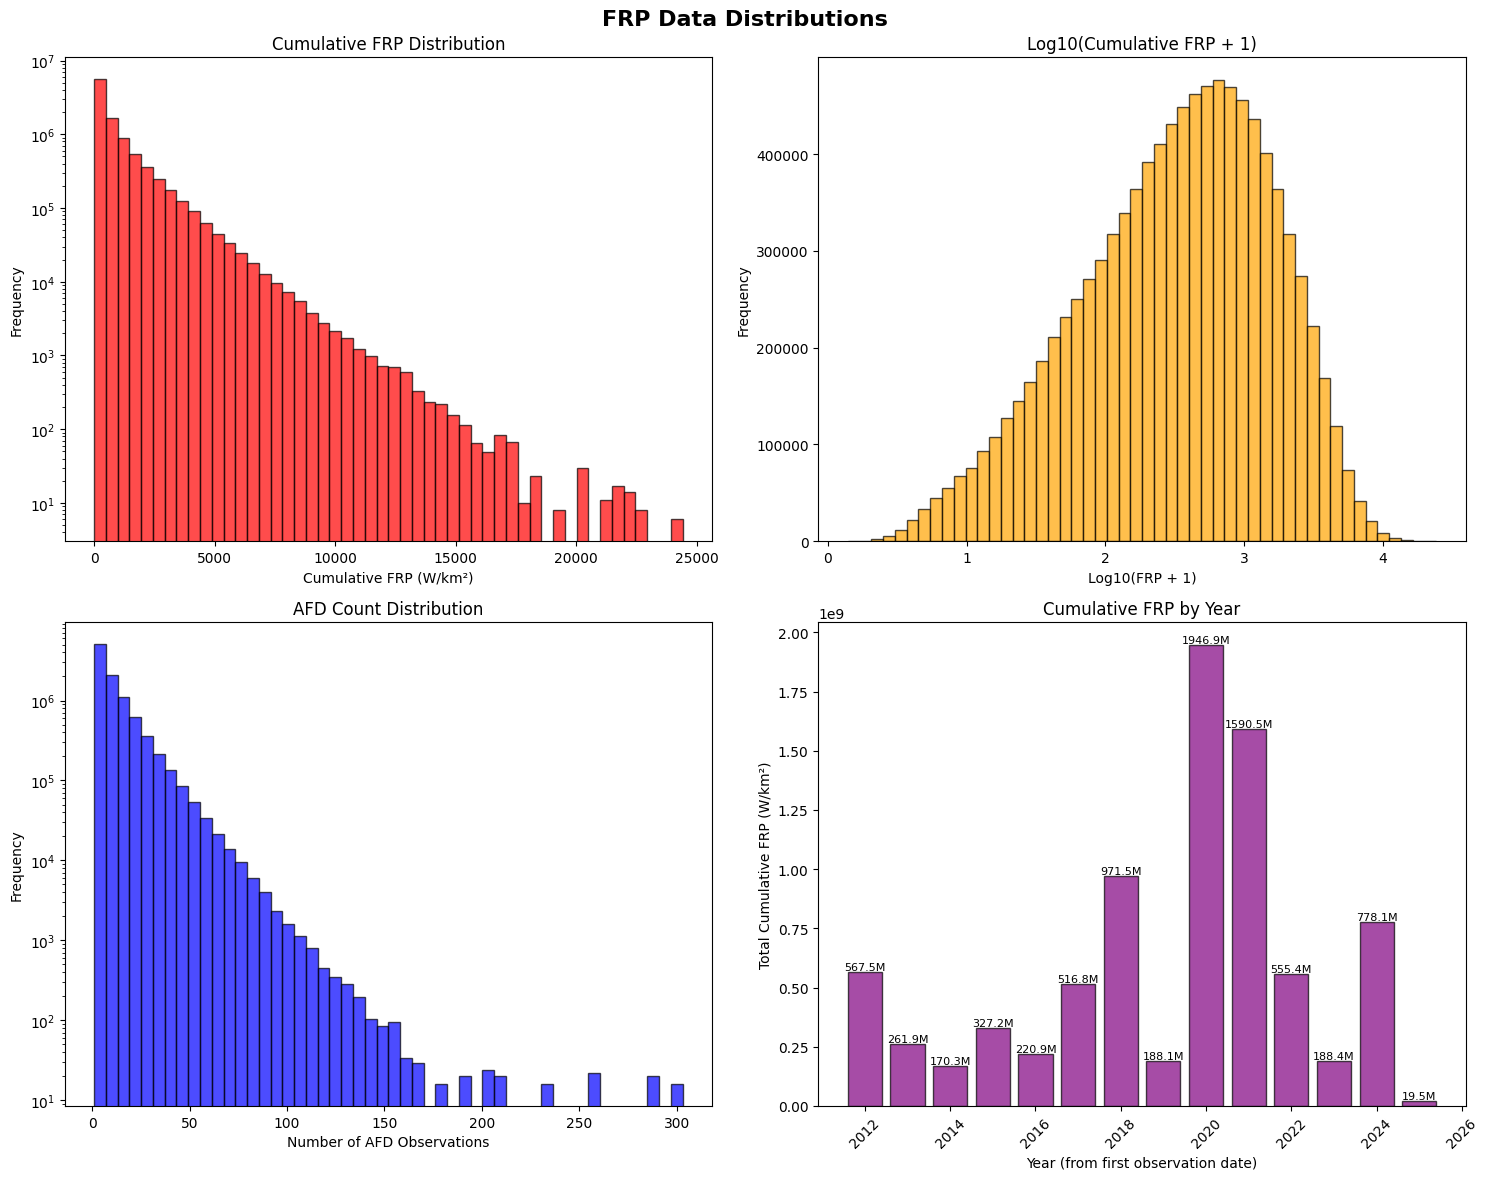

In [7]:
# Distribution plots
if 'gridstats' in locals() and 'frp_csum' in gridstats.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('FRP Data Distributions', fontsize=16, fontweight='bold')
    
    # Cumulative FRP distribution
    axes[0,0].hist(gridstats['frp_csum'], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0,0].set_title('Cumulative FRP Distribution')
    axes[0,0].set_xlabel('Cumulative FRP (W/km²)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_yscale('log')
    
    # Log-scale FRP
    log_frp = np.log10(gridstats['frp_csum'] + 1)
    axes[0,1].hist(log_frp, bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0,1].set_title('Log10(Cumulative FRP + 1)')
    axes[0,1].set_xlabel('Log10(FRP + 1)')
    axes[0,1].set_ylabel('Frequency')
    
    # AFD count distribution
    if 'afd_count' in gridstats.columns:
        axes[1,0].hist(gridstats['afd_count'], bins=50, alpha=0.7, color='blue', edgecolor='black')
        axes[1,0].set_title('AFD Count Distribution')
        axes[1,0].set_xlabel('Number of AFD Observations')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].set_yscale('log')
    
    # Cumulative FRP by Year (from first_obs_date)
    if 'first_obs_date' in gridstats.columns:
        # Convert first_obs_date to datetime and extract year
        gridstats_temp = gridstats.copy()
        gridstats_temp['first_obs_date'] = pd.to_datetime(gridstats_temp['first_obs_date'])
        gridstats_temp['obs_year'] = gridstats_temp['first_obs_date'].dt.year
        
        # Group by year and sum FRP
        yearly_frp = gridstats_temp.groupby('obs_year')['frp_csum'].sum().reset_index()
        yearly_frp = yearly_frp.sort_values('obs_year')
        
        # Create bar plot
        bars = axes[1,1].bar(yearly_frp['obs_year'], yearly_frp['frp_csum'], 
                            alpha=0.7, color='purple', edgecolor='black')
        axes[1,1].set_title('Cumulative FRP by Year')
        axes[1,1].set_xlabel('Year (from first observation date)')
        axes[1,1].set_ylabel('Total Cumulative FRP (W/km²)')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars for readability
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                axes[1,1].text(bar.get_x() + bar.get_width()/2., height,
                              f'{height/1e6:.1f}M', ha='center', va='bottom', fontsize=8)
        
        print(f"Years covered: {yearly_frp['obs_year'].min()} - {yearly_frp['obs_year'].max()}")
        print(f"Peak FRP year: {yearly_frp.loc[yearly_frp['frp_csum'].idxmax(), 'obs_year']} "
              f"({yearly_frp['frp_csum'].max()/1e6:.1f} MW/km²)")
    else:
        # Fallback to percentiles if first_obs_date not available
        percentile_cols = [col for col in ['frp_p90', 'frp_p95', 'frp_p97', 'frp_p99'] if col in gridstats.columns]
        if percentile_cols:
            for i, col in enumerate(percentile_cols):
                axes[1,1].hist(gridstats[col], bins=30, alpha=0.6, label=col, edgecolor='black')
            axes[1,1].set_title('FRP Percentiles Distribution')
            axes[1,1].set_xlabel('FRP (W/km²)')
            axes[1,1].set_ylabel('Frequency')
            axes[1,1].legend()
            axes[1,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()


ANALYSIS 1: FRP PER FIRE BY YEAR


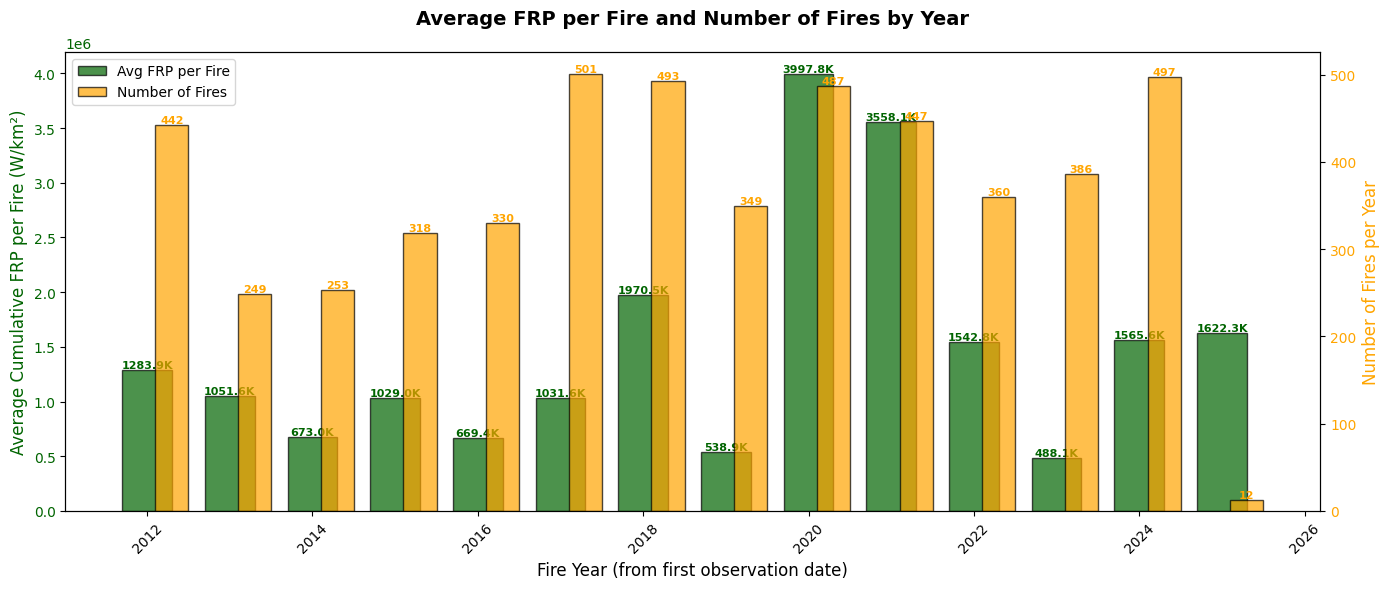


Summary Statistics:
Years analyzed: 2012 - 2025
Average fires per year: 366.0
Average FRP per fire across all years: 1501.6K W/km²
Highest average FRP per fire: 2020.0 (3997.8K W/km²)

Year-by-year breakdown:
  2012: 442 fires, 1283.9K W/km² per fire
  2013: 249 fires, 1051.6K W/km² per fire
  2014: 253 fires, 673.0K W/km² per fire
  2015: 318 fires, 1029.0K W/km² per fire
  2016: 330 fires, 669.4K W/km² per fire
  2017: 501 fires, 1031.6K W/km² per fire
  2018: 493 fires, 1970.5K W/km² per fire
  2019: 349 fires, 538.9K W/km² per fire
  2020: 487 fires, 3997.8K W/km² per fire
  2021: 447 fires, 3558.1K W/km² per fire
  2022: 360 fires, 1542.8K W/km² per fire
  2023: 386 fires, 488.1K W/km² per fire
  2024: 497 fires, 1565.6K W/km² per fire
  2025: 12 fires, 1622.3K W/km² per fire


In [8]:
# Additional Analysis 1: Standardized Year-to-Year FRP Comparison
print("="*60)
print("ANALYSIS 1: FRP PER FIRE BY YEAR")
print("="*60)

if 'gridstats' in locals() and 'frp_csum' in gridstats.columns and 'merge_id' in gridstats.columns:
    # Need to get fire year information - will need to load fire data or use first_obs_date
    if 'first_obs_date' in gridstats.columns:
        # Use first_obs_date as proxy for fire year
        gridstats_temp = gridstats.copy()
        gridstats_temp['first_obs_date'] = pd.to_datetime(gridstats_temp['first_obs_date'])
        gridstats_temp['fire_year'] = gridstats_temp['first_obs_date'].dt.year
        
        # Aggregate by fire (merge_id) and year
        fire_yearly = gridstats_temp.groupby(['merge_id', 'fire_year']).agg({
            'frp_csum': 'sum'
        }).reset_index()
        
        # Calculate metrics by year
        yearly_metrics = fire_yearly.groupby('fire_year').agg({
            'frp_csum': 'sum',           # Total FRP for the year
            'merge_id': 'count'          # Number of fires for the year
        }).reset_index()
        
        yearly_metrics.columns = ['fire_year', 'total_frp', 'num_fires']
        yearly_metrics['frp_per_fire'] = yearly_metrics['total_frp'] / yearly_metrics['num_fires']
        yearly_metrics = yearly_metrics.sort_values('fire_year')
        
        # Create the plot with dual y-axes
        fig, ax1 = plt.subplots(1, 1, figsize=(14, 6))
        
        # Plot 1: Average FRP per fire (left y-axis)
        bars1 = ax1.bar(yearly_metrics['fire_year'], yearly_metrics['frp_per_fire'], 
                        alpha=0.7, color='darkgreen', edgecolor='black', width=0.6, 
                        label='Avg FRP per Fire')
        ax1.set_xlabel('Fire Year (from first observation date)', fontsize=12)
        ax1.set_ylabel('Average Cumulative FRP per Fire (W/km²)', color='darkgreen', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='darkgreen')
        ax1.tick_params(axis='x', rotation=45)
        
        # Add value labels on FRP bars
        for bar in bars1:
            height = bar.get_height()
            if height > 0:
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{height/1e3:.1f}K', ha='center', va='bottom', fontsize=8, 
                        color='darkgreen', fontweight='bold')
        
        # Create second y-axis for number of fires
        ax2 = ax1.twinx()
        
        # Plot 2: Number of fires per year (right y-axis) - offset slightly for visibility
        bars2 = ax2.bar(yearly_metrics['fire_year'] + 0.3, yearly_metrics['num_fires'], 
                        alpha=0.7, color='orange', edgecolor='black', width=0.4,
                        label='Number of Fires')
        ax2.set_ylabel('Number of Fires per Year', color='orange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Add value labels on fire count bars
        for bar in bars2:
            height = bar.get_height()
            if height > 0:
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}', ha='center', va='bottom', fontsize=8, 
                        color='orange', fontweight='bold')
        
        # Title and legend
        ax1.set_title('Average FRP per Fire and Number of Fires by Year', 
                     fontsize=14, fontweight='bold', pad=20)
        
        # Create combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Display summary statistics
        print(f"\nSummary Statistics:")
        print(f"Years analyzed: {yearly_metrics['fire_year'].min()} - {yearly_metrics['fire_year'].max()}")
        print(f"Average fires per year: {yearly_metrics['num_fires'].mean():.1f}")
        print(f"Average FRP per fire across all years: {yearly_metrics['frp_per_fire'].mean()/1e3:.1f}K W/km²")
        
        peak_year = yearly_metrics.loc[yearly_metrics['frp_per_fire'].idxmax()]
        print(f"Highest average FRP per fire: {peak_year['fire_year']} ({peak_year['frp_per_fire']/1e3:.1f}K W/km²)")
        
        print(f"\nYear-by-year breakdown:")
        for _, row in yearly_metrics.iterrows():
            print(f"  {int(row['fire_year'])}: {int(row['num_fires'])} fires, "
                  f"{row['frp_per_fire']/1e3:.1f}K W/km² per fire")
    else:
        print("Warning: 'first_obs_date' column not found. Cannot perform year-to-year analysis.")
else:
    print("Warning: Required columns not found in gridstats data.")


ANALYSIS 2: FRP vs FIRE DURATION RELATIONSHIP
Using 'event_dur' from raw FIRED dataset instead of 'day_count'
Successfully merged 5111 fires with both FRP and event duration data
Analyzing 5111 fires with valid FRP and duration data

Checking statistical assumptions...
Fire duration source: event_dur from raw FIRED


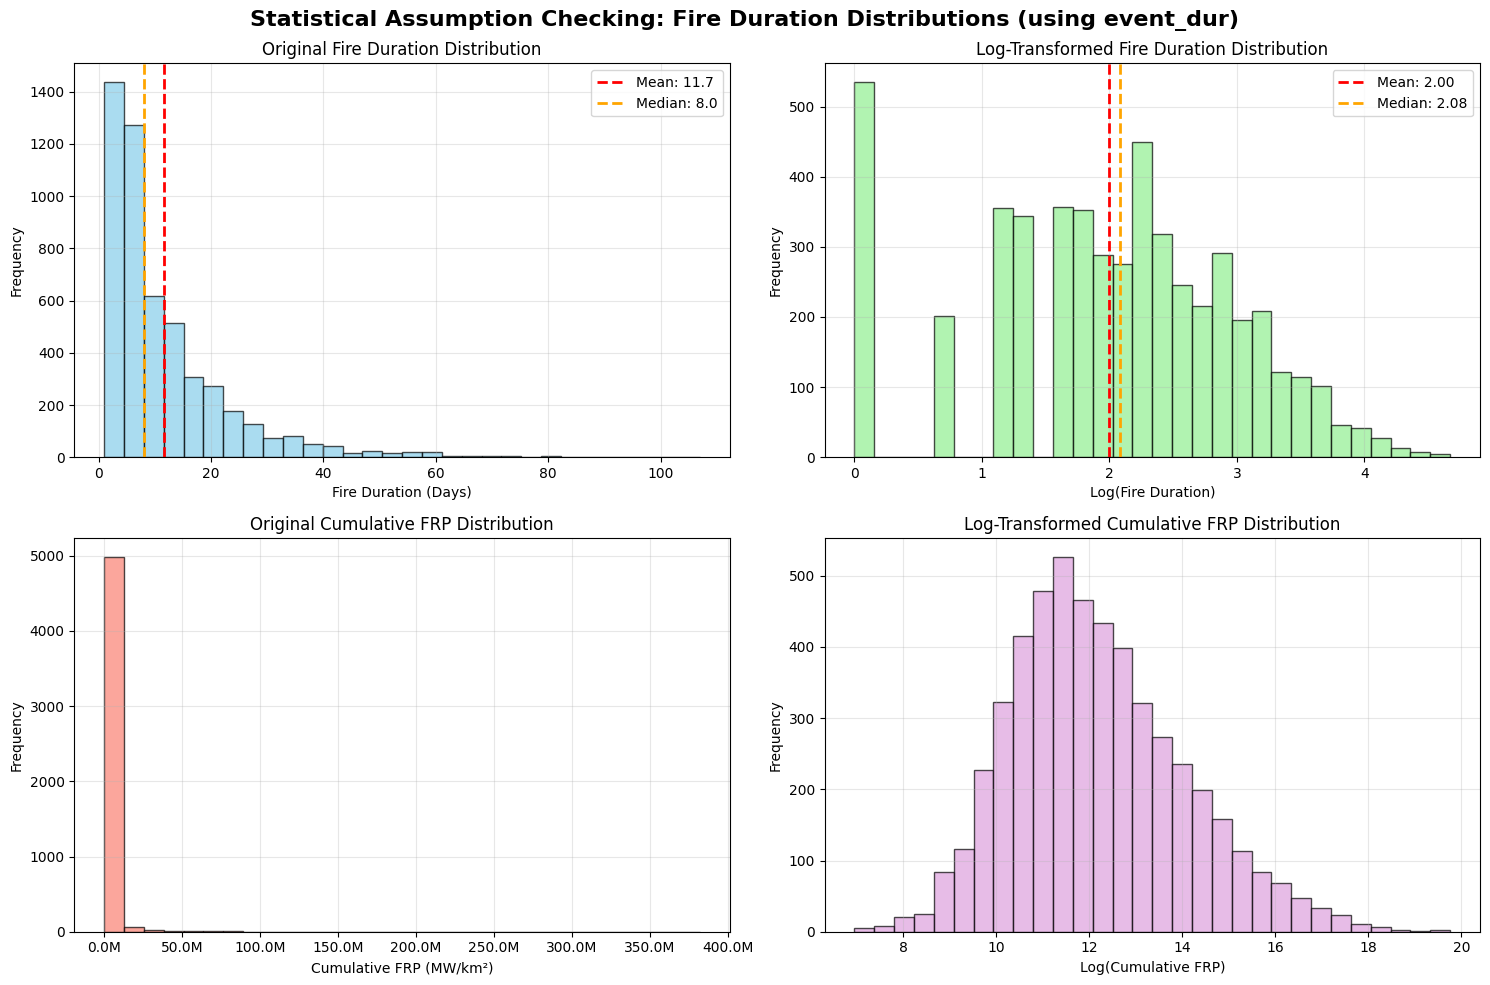


Distribution Statistics:
Fire Duration (original):
  - Skewness: 2.404
  - Range: 1 - 107 days
  - Mean: 11.7, Median: 8.0, Std: 11.7
  - Normality test p-value: 0.00e+00 (Non-normal)

Fire Duration (log-transformed):
  - Skewness: -0.320
  - Range: 0.00 - 4.67
  - Mean: 2.00, Median: 2.08, Std: 1.02
  - Normality test p-value: 1.99e-29 (Non-normal)

Fire Duration (square root-transformed):
  - Skewness: 0.925
  - Range: 1.00 - 10.34
  - Mean: 3.07, Median: 2.83, Std: 1.50
  - Normality test p-value: 3.62e-141 (Non-normal)

Transformation Comparison (by skewness):
  - Original: 2.404
  - Log: 0.320
  - Square Root: 0.925
  - Best transformation: Log (skewness = 0.320)


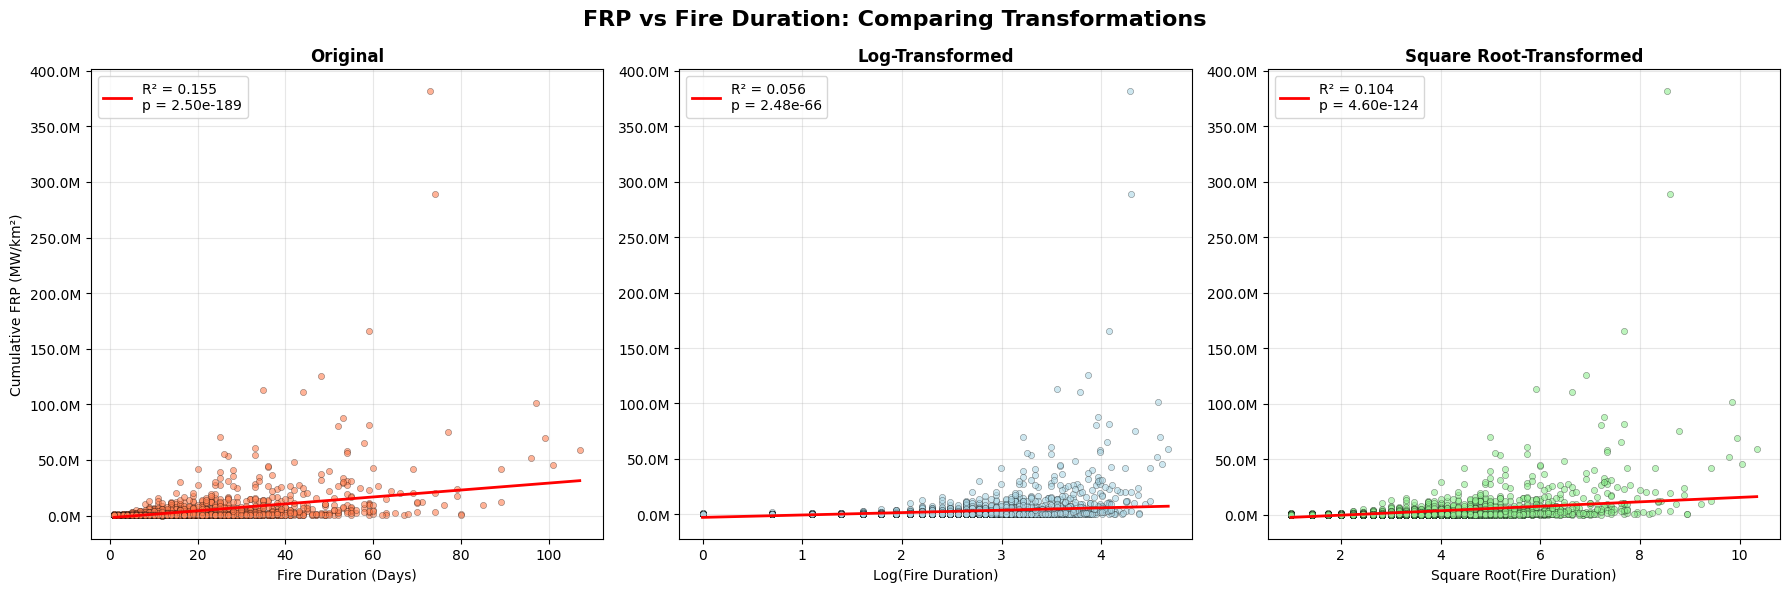


CORRELATION ANALYSIS: COMPARING TRANSFORMATIONS

Original:
  - Pearson correlation: 0.3939
  - R-squared: 0.1552
  - P-value: 2.50e-189
  - Significance: ✓ Significant
  - Linear equation: y = 311613.57x + -2006634

Log-Transformed:
  - Pearson correlation: 0.2373
  - R-squared: 0.0563
  - P-value: 2.48e-66
  - Significance: ✓ Significant
  - Linear equation: y = 2157299.27x + -2681305

Square Root-Transformed:
  - Pearson correlation: 0.3225
  - R-squared: 0.1040
  - P-value: 4.60e-124
  - Significance: ✓ Significant
  - Linear equation: y = 2000891.85x + -4512723

Best transformation by R²: Original (R² = 0.1552)

Summary Statistics:
Fire duration range: 1 - 107 days
Average fire duration: 11.7 days
FRP range: 1.0K - 382.1M W/km²
Average FRP per fire: 1624.5K W/km²

Notable Fires:
Longest duration: Fire 199712.0 (107 days, 58801.6K W/km²)
Highest FRP: Fire 198991.0 (382.1M W/km², 73 days)


In [9]:
# Additional Analysis 2: Relationship between Cumulative FRP and Fire Duration
print("="*60)
print("ANALYSIS 2: FRP vs FIRE DURATION RELATIONSHIP")
print("="*60)

if 'gridstats' in locals() and 'frp_csum' in gridstats.columns and 'merge_id' in gridstats.columns:
    # Check if we have the raw FIRED data with event_dur column
    if 'raw_fired_with_frp' in locals() and 'event_dur' in raw_fired_with_frp.columns:
        # Aggregate by fire (merge_id) - sum FRP from gridstats
        fire_metrics = gridstats.groupby('merge_id').agg({
            'frp_csum': 'sum'           # Total cumulative FRP for each fire
        }).reset_index()
        
        # Merge with raw FIRED data to get event_dur
        fire_metrics = fire_metrics.merge(
            raw_fired_with_frp[['merge_id', 'event_dur']], 
            on='merge_id', 
            how='inner'
        )
        
        print(f"Using 'event_dur' from raw FIRED dataset instead of 'day_count'")
        print(f"Successfully merged {len(fire_metrics)} fires with both FRP and event duration data")
        
        # Remove any fires with zero or missing values
        fire_metrics = fire_metrics[(fire_metrics['frp_csum'] > 0) & (fire_metrics['event_dur'] > 0)]
        
        # Rename for consistency with the rest of the code
        fire_metrics = fire_metrics.rename(columns={'event_dur': 'day_count'})
        
    elif 'day_count' in gridstats.columns:
        # Fallback to original method if raw FIRED data not available
        print("Raw FIRED data not available, using 'day_count' from gridstats")
        fire_metrics = gridstats.groupby('merge_id').agg({
            'frp_csum': 'sum',           # Total cumulative FRP for each fire
            'day_count': 'first'         # Fire duration in days (should be same for all grid cells of same fire)
        }).reset_index()
        
        # Remove any fires with zero or missing values
        fire_metrics = fire_metrics[(fire_metrics['frp_csum'] > 0) & (fire_metrics['day_count'] > 0)]
        
    else:
        print("Error: Neither 'event_dur' from raw FIRED nor 'day_count' from gridstats available")
        fire_metrics = None
        
    if fire_metrics is not None and len(fire_metrics) > 0:
        print(f"Analyzing {len(fire_metrics)} fires with valid FRP and duration data")
        
        # Statistical assumption checking: Check distribution of fire duration
        print(f"\nChecking statistical assumptions...")
        print(f"Fire duration source: {'event_dur from raw FIRED' if 'raw_fired_with_frp' in locals() and 'event_dur' in raw_fired_with_frp.columns else 'day_count from gridstats'}")
        
        # Create histograms to check data distribution
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Statistical Assumption Checking: Fire Duration Distributions (using event_dur)', fontsize=16, fontweight='bold')
        
        # 1. Original fire duration histogram
        axes[0,0].hist(fire_metrics['day_count'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Original Fire Duration Distribution')
        axes[0,0].set_xlabel('Fire Duration (Days)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add statistics to the plot
        mean_days = fire_metrics['day_count'].mean()
        median_days = fire_metrics['day_count'].median()
        std_days = fire_metrics['day_count'].std()
        axes[0,0].axvline(mean_days, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_days:.1f}')
        axes[0,0].axvline(median_days, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_days:.1f}')
        axes[0,0].legend()
        
        # 2. Log-transformed fire duration histogram
        log_days = np.log(fire_metrics['day_count'])
        axes[0,1].hist(log_days, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0,1].set_title('Log-Transformed Fire Duration Distribution')
        axes[0,1].set_xlabel('Log(Fire Duration)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].grid(True, alpha=0.3)
        
        # Add statistics to log plot
        mean_log = log_days.mean()
        median_log = np.median(log_days)
        axes[0,1].axvline(mean_log, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_log:.2f}')
        axes[0,1].axvline(median_log, color='orange', linestyle='--', linewidth=2, label=f'Median: {median_log:.2f}')
        axes[0,1].legend()
        
        # Square root transformation for comparison
        sqrt_days = np.sqrt(fire_metrics['day_count'])
        
        # 3. Original FRP histogram
        axes[1,0].hist(fire_metrics['frp_csum'], bins=30, alpha=0.7, color='salmon', edgecolor='black')
        axes[1,0].set_title('Original Cumulative FRP Distribution')
        axes[1,0].set_xlabel('Cumulative FRP (W/km²)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].grid(True, alpha=0.3)
        
        # Format x-axis for FRP
        if fire_metrics['frp_csum'].max() > 1e6:
            axes[1,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            axes[1,0].set_xlabel('Cumulative FRP (MW/km²)')
        elif fire_metrics['frp_csum'].max() > 1e3:
            axes[1,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            axes[1,0].set_xlabel('Cumulative FRP (KW/km²)')
        
        # 4. Log-transformed FRP histogram
        log_frp = np.log(fire_metrics['frp_csum'])
        axes[1,1].hist(log_frp, bins=30, alpha=0.7, color='plum', edgecolor='black')
        axes[1,1].set_title('Log-Transformed Cumulative FRP Distribution')
        axes[1,1].set_xlabel('Log(Cumulative FRP)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Calculate skewness and normality tests
        from scipy.stats import skew, normaltest
        
        print(f"\nDistribution Statistics:")
        print(f"Fire Duration (original):")
        print(f"  - Skewness: {skew(fire_metrics['day_count']):.3f}")
        print(f"  - Range: {fire_metrics['day_count'].min():.0f} - {fire_metrics['day_count'].max():.0f} days")
        print(f"  - Mean: {mean_days:.1f}, Median: {median_days:.1f}, Std: {std_days:.1f}")
        
        # Normality test for original data
        stat_orig, p_orig = normaltest(fire_metrics['day_count'])
        print(f"  - Normality test p-value: {p_orig:.2e} {'(Normal)' if p_orig > 0.05 else '(Non-normal)'}")
        
        print(f"\nFire Duration (log-transformed):")
        print(f"  - Skewness: {skew(log_days):.3f}")
        print(f"  - Range: {log_days.min():.2f} - {log_days.max():.2f}")
        print(f"  - Mean: {mean_log:.2f}, Median: {median_log:.2f}, Std: {log_days.std():.2f}")
        
        # Normality test for log-transformed data
        stat_log, p_log = normaltest(log_days)
        print(f"  - Normality test p-value: {p_log:.2e} {'(Normal)' if p_log > 0.05 else '(Non-normal)'}")
        
        print(f"\nFire Duration (square root-transformed):")
        print(f"  - Skewness: {skew(sqrt_days):.3f}")
        print(f"  - Range: {sqrt_days.min():.2f} - {sqrt_days.max():.2f}")
        print(f"  - Mean: {sqrt_days.mean():.2f}, Median: {np.median(sqrt_days):.2f}, Std: {sqrt_days.std():.2f}")
        
        # Normality test for sqrt-transformed data
        stat_sqrt, p_sqrt = normaltest(sqrt_days)
        print(f"  - Normality test p-value: {p_sqrt:.2e} {'(Normal)' if p_sqrt > 0.05 else '(Non-normal)'}")
        
        # Compare transformations
        original_skew = abs(skew(fire_metrics['day_count']))
        log_skew = abs(skew(log_days))
        sqrt_skew = abs(skew(sqrt_days))
        
        best_transform = min([
            ('Original', original_skew),
            ('Log', log_skew),
            ('Square Root', sqrt_skew)
        ], key=lambda x: x[1])
        
        print(f"\nTransformation Comparison (by skewness):")
        print(f"  - Original: {original_skew:.3f}")
        print(f"  - Log: {log_skew:.3f}")
        print(f"  - Square Root: {sqrt_skew:.3f}")
        print(f"  - Best transformation: {best_transform[0]} (skewness = {best_transform[1]:.3f})")
        
        # Create three scatter plots with different transformations
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('FRP vs Fire Duration: Comparing Transformations', fontsize=16, fontweight='bold')
        
        from scipy import stats
        import numpy as np
        
        # Prepare data for all three transformations
        transformations = [
            ('Original', fire_metrics['day_count'], 'Fire Duration (Days)'),
            ('Log-Transformed', log_days, 'Log(Fire Duration)'),
            ('Square Root-Transformed', sqrt_days, 'Square Root(Fire Duration)')
        ]
        
        colors = ['coral', 'lightblue', 'lightgreen']
        
        # Create scatter plots for each transformation
        for i, (transform_name, x_data, x_label) in enumerate(transformations):
            ax = axes[i]
            
            # Scatter plot
            scatter = ax.scatter(x_data, fire_metrics['frp_csum'], 
                               alpha=0.6, c=colors[i], s=20, edgecolors='black', linewidth=0.3)
            
            # Calculate linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, fire_metrics['frp_csum'])
            
            # Create line of best fit
            x_line = np.linspace(x_data.min(), x_data.max(), 100)
            y_line = slope * x_line + intercept
            
            ax.plot(x_line, y_line, 'red', linewidth=2, 
                   label=f'R² = {r_value**2:.3f}\np = {p_value:.2e}')
            
            # Formatting
            ax.set_title(f'{transform_name}', fontsize=12, fontweight='bold')
            ax.set_xlabel(x_label)
            ax.set_ylabel('Cumulative FRP (W/km²)' if i == 0 else '')
            ax.legend(loc='upper left')
            ax.grid(True, alpha=0.3)
            
            # Format y-axis for first plot only
            if i == 0:
                if fire_metrics['frp_csum'].max() > 1e6:
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
                    ax.set_ylabel('Cumulative FRP (MW/km²)')
                elif fire_metrics['frp_csum'].max() > 1e3:
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
                    ax.set_ylabel('Cumulative FRP (KW/km²)')
            
            # Apply same y-axis formatting to other plots
            if i > 0:
                if fire_metrics['frp_csum'].max() > 1e6:
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
                elif fire_metrics['frp_csum'].max() > 1e3:
                    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
        
        plt.tight_layout()
        plt.show()
        
        # Display detailed correlation statistics for all transformations
        print(f"\n" + "="*80)
        print("CORRELATION ANALYSIS: COMPARING TRANSFORMATIONS")
        print("="*80)
        
        for transform_name, x_data, _ in transformations:
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, fire_metrics['frp_csum'])
            
            print(f"\n{transform_name}:")
            print(f"  - Pearson correlation: {r_value:.4f}")
            print(f"  - R-squared: {r_value**2:.4f}")
            print(f"  - P-value: {p_value:.2e}")
            print(f"  - Significance: {'✓ Significant' if p_value < 0.05 else '✗ Not significant'}")
            print(f"  - Linear equation: y = {slope:.2f}x + {intercept:.0f}")
        
        # Identify best transformation by R²
        r_squared_values = []
        for transform_name, x_data, _ in transformations:
            _, _, r_value, _, _ = stats.linregress(x_data, fire_metrics['frp_csum'])
            r_squared_values.append((transform_name, r_value**2))
        
        best_r2 = max(r_squared_values, key=lambda x: x[1])
        print(f"\nBest transformation by R²: {best_r2[0]} (R² = {best_r2[1]:.4f})")
        

        
        # Summary statistics
        print(f"\nSummary Statistics:")
        print(f"Fire duration range: {fire_metrics['day_count'].min():.0f} - {fire_metrics['day_count'].max():.0f} days")
        print(f"Average fire duration: {fire_metrics['day_count'].mean():.1f} days")
        print(f"FRP range: {fire_metrics['frp_csum'].min()/1e3:.1f}K - {fire_metrics['frp_csum'].max()/1e6:.1f}M W/km²")
        print(f"Average FRP per fire: {fire_metrics['frp_csum'].mean()/1e3:.1f}K W/km²")
        
        # Identify outliers
        longest_fire = fire_metrics.loc[fire_metrics['day_count'].idxmax()]
        highest_frp = fire_metrics.loc[fire_metrics['frp_csum'].idxmax()]
        
        print(f"\nNotable Fires:")
        print(f"Longest duration: Fire {longest_fire['merge_id']} ({longest_fire['day_count']:.0f} days, "
              f"{longest_fire['frp_csum']/1e3:.1f}K W/km²)")
        print(f"Highest FRP: Fire {highest_frp['merge_id']} ({highest_frp['frp_csum']/1e6:.1f}M W/km², "
              f"{highest_frp['day_count']:.0f} days)")
        
    else:
        if fire_metrics is None:
            print("Cannot proceed with analysis - no valid fire metrics data")
        else:
            print("No valid fire data found after filtering")
else:
    print("Warning: Required columns not found in gridstats data.")


LOADING WWF ECOREGIONS AND FILTERING TO WESTERN US AOI
✓ Loaded AOI from: data/input/AOI/westUS_5070.gpkg
  - AOI CRS: EPSG:5070
  - AOI features: 11

Looking for WWF ecoregion folder: data\input\AOI\wwf_eco
✓ Found WWF ecoregion folder
✓ Found existing GeoPackage, loading: data\input\AOI\wwf_eco\wwf_terr_ecos.gpkg
✓ Loaded 14458 total ecoregions
  - CRS: EPSG:4326
  - Columns: ['OBJECTID', 'AREA', 'PERIMETER', 'ECO_NAME', 'REALM', 'BIOME', 'ECO_NUM', 'ECO_ID', 'ECO_SYM', 'GBL_STAT', 'G200_REGIO', 'G200_NUM', 'G200_BIOME', 'G200_STAT', 'Shape_Leng', 'Shape_Area', 'area_km2', 'eco_code', 'PER_area', 'PER_area_1', 'PER_area_2', 'geometry']

Filtering ecoregions to those overlapping the AOI...
  - Reprojecting ecoregions from EPSG:4326 to match AOI CRS (EPSG:5070)...
✓ Filtered to 205 ecoregions overlapping AOI
✓ Saved filtered ecoregions to: data\input\AOI\wwf_eco\wwf_terr_ecos_western_us.gpkg

Creating visualization...


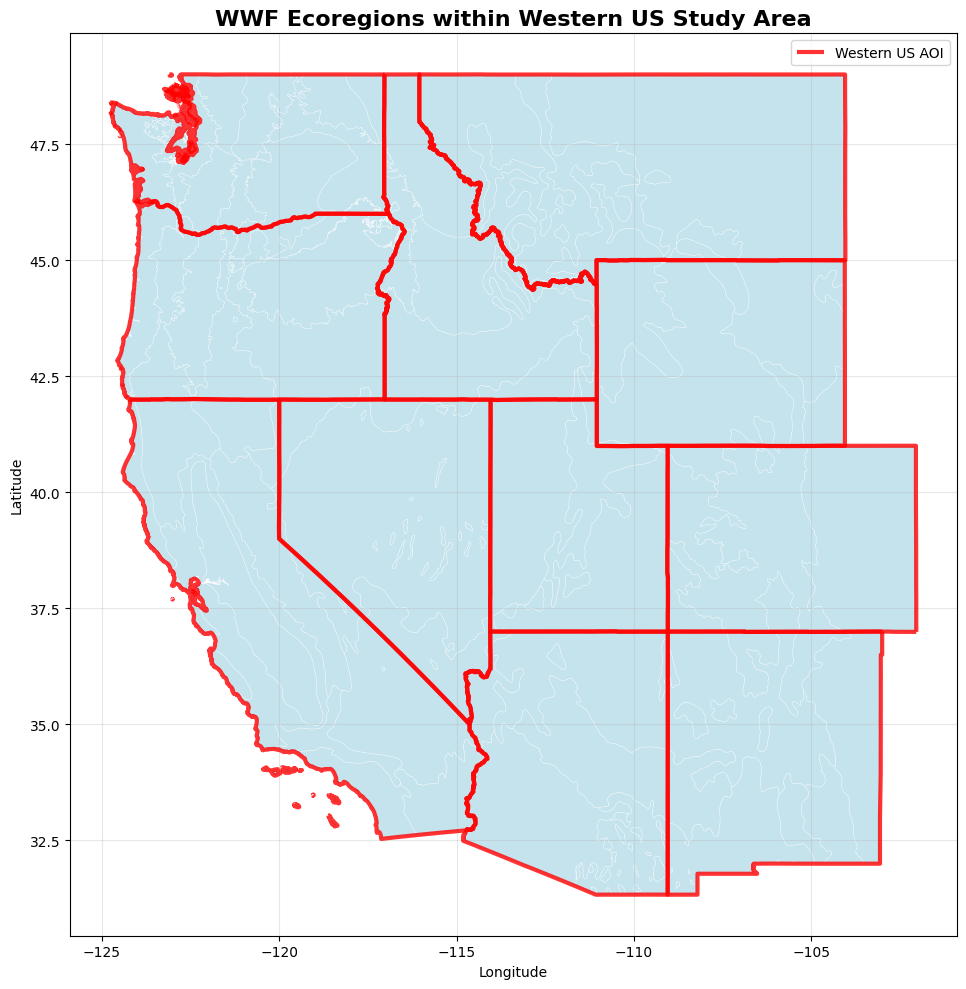


ECOREGION FILTERING COMPLETE
Total ecoregions in AOI: 205
Unique ecoregion names: 37
Data ready for comprehensive analysis...


In [11]:
# ============================================================================
# LOAD AND FILTER WWF ECOREGIONS TO AOI
# ============================================================================
print("="*80)
print("LOADING WWF ECOREGIONS AND FILTERING TO WESTERN US AOI")
print("="*80)

# Load AOI first - check multiple possible locations
aoi_paths = [
    "data/input/AOI/westUS_5070.gpkg",
    "data/input/AOI/westUS.gpkg", 
    "../data/input/AOI/westUS_5070.gpkg",
    "../data/input/AOI/westUS.gpkg"
]

aoi = None
for aoi_path in aoi_paths:
    try:
        if Path(aoi_path).exists():
            aoi = gpd.read_file(aoi_path)
            print(f"✓ Loaded AOI from: {aoi_path}")
            print(f"  - AOI CRS: {aoi.crs}")
            print(f"  - AOI features: {len(aoi)}")
            break
    except Exception as e:
        continue

if aoi is None:
    print("❌ AOI not found - will process all ecoregions (no spatial filtering)")

# Load WWF Ecoregions
eco_folder = Path("data/input/AOI/wwf_eco")
if not eco_folder.exists():
    eco_folder = Path.cwd() / "data" / "input" / "AOI" / "wwf_eco"
if not eco_folder.exists():
    eco_folder = Path.cwd().parent / "data" / "input" / "AOI" / "wwf_eco"

print(f"\nLooking for WWF ecoregion folder: {eco_folder}")

if eco_folder.exists():
    print(f"✓ Found WWF ecoregion folder")
    
    # Check for existing .gpkg file first
    gpkg_path = eco_folder / "wwf_terr_ecos.gpkg"
    
    if gpkg_path.exists():
        print(f"✓ Found existing GeoPackage, loading: {gpkg_path}")
        ecoregions_full = gpd.read_file(gpkg_path)
    else:
        # Look for the specific WWF shapefile
        shp_file = eco_folder / "wwf_terr_ecos.shp"
        if shp_file.exists():
            print(f"✓ Found WWF shapefile, converting to GeoPackage: {shp_file}")
            ecoregions_full = gpd.read_file(shp_file)
            ecoregions_full.to_file(gpkg_path, driver='GPKG')
            print(f"✓ Saved as GeoPackage: {gpkg_path}")
        else:
            print("❌ WWF shapefile not found at expected location")
            print(f"Looking for any .shp files in {eco_folder}:")
            shp_files = list(eco_folder.glob("*.shp"))
            if shp_files:
                shp_file = shp_files[0]
                print(f"✓ Found shapefile: {shp_file}")
                ecoregions_full = gpd.read_file(shp_file)
                ecoregions_full.to_file(gpkg_path, driver='GPKG')
                print(f"✓ Saved as GeoPackage: {gpkg_path}")
            else:
                print("❌ No shapefile found in WWF ecoregion folder")
                ecoregions_full = None
    
    if ecoregions_full is not None:
        print(f"✓ Loaded {len(ecoregions_full)} total ecoregions")
        print(f"  - CRS: {ecoregions_full.crs}")
        print(f"  - Columns: {list(ecoregions_full.columns)}")
        
        # Filter ecoregions to only those overlapping the AOI
        if aoi is not None:
            print(f"\nFiltering ecoregions to those overlapping the AOI...")
            
            # Ensure same CRS for intersection
            if ecoregions_full.crs != aoi.crs:
                print(f"  - Reprojecting ecoregions from {ecoregions_full.crs} to match AOI CRS ({aoi.crs})...")
                ecoregions_full = ecoregions_full.to_crs(aoi.crs)
            
            # Filter ecoregions using spatial intersection
            ecoregions_filtered = gpd.overlay(ecoregions_full, aoi, how='intersection')
            print(f"✓ Filtered to {len(ecoregions_filtered)} ecoregions overlapping AOI")
            
            # Save the filtered WWF ecoregions for later use
            filtered_gpkg_path = eco_folder / "wwf_terr_ecos_western_us.gpkg"
            ecoregions_filtered.to_file(filtered_gpkg_path, driver='GPKG')
            print(f"✓ Saved filtered ecoregions to: {filtered_gpkg_path}")
        else:
            print("\n⚠️ AOI not found, using all ecoregions")
            ecoregions_filtered = ecoregions_full
        
        # Plot filtered ecoregions over AOI
        print(f"\nCreating visualization...")
        fig, ax = plt.subplots(figsize=(16, 10))
        
        # Plot filtered ecoregions
        ecoregions_plot = ecoregions_filtered.to_crs('EPSG:4326') if ecoregions_filtered.crs != 'EPSG:4326' else ecoregions_filtered
        ecoregions_plot.plot(ax=ax, facecolor='lightblue', edgecolor='white', linewidth=0.3, alpha=0.7)
        
        # Overlay AOI boundary if available
        if aoi is not None:
            aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
            aoi_plot.boundary.plot(ax=ax, color='red', linewidth=3, alpha=0.8, label='Western US AOI')
            ax.legend()
        
        ax.set_title('WWF Ecoregions within Western US Study Area', fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Store the filtered ecoregions for use in subsequent analysis
        ecoregions = ecoregions_filtered  # This will be used by the comprehensive analysis
        
        print(f"\n{'='*50}")
        print(f"ECOREGION FILTERING COMPLETE")
        print(f"{'='*50}")
        print(f"Total ecoregions in AOI: {len(ecoregions)}")
        if 'ECO_NAME' in ecoregions.columns:
            print(f"Unique ecoregion names: {len(ecoregions['ECO_NAME'].unique())}")
        print(f"Data ready for comprehensive analysis...")
        
else:
    print("❌ Ecoregion folder not found!")
    ecoregions = None
    ecoregions_filtered = None

COMPREHENSIVE ECOREGION AND FIRE ANALYSIS
✓ Using pre-loaded filtered ecoregions (205 ecoregions)

STEP 2: FRP ANALYSIS BY ECOREGION
Analyzing 5111 fires across ecoregions
Found 31 ecoregions with >= 10 fires


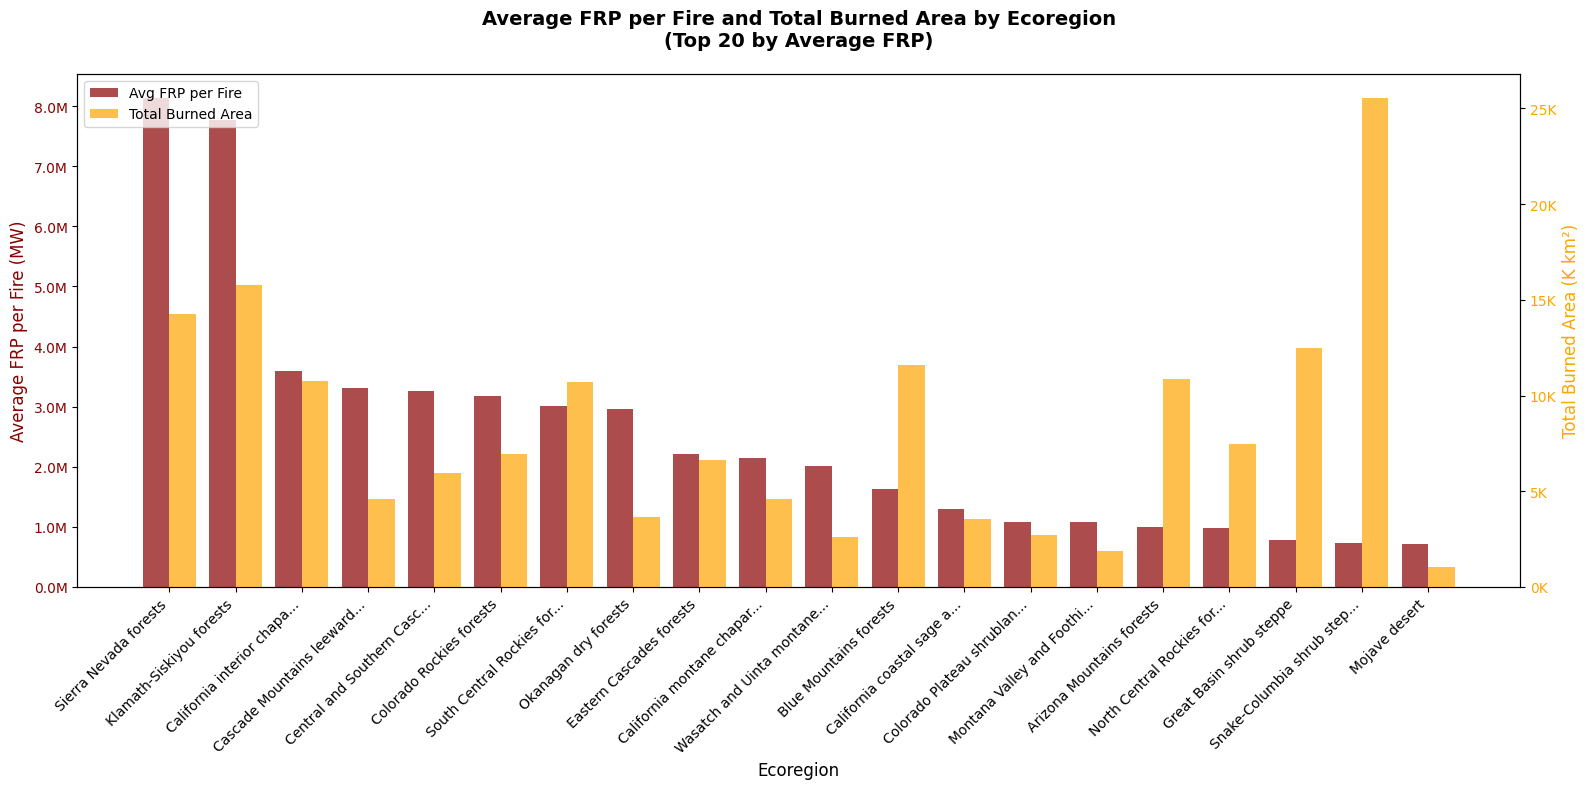


=== ECOREGION SUMMARY STATISTICS ===
All 31 ecoregions (sorted by average FRP per fire):
Ecoregion Name                                     | Avg FRP    | Fires  | Total Area   | Avg Size  
----------------------------------------------------------------------------------------------------
Sierra Nevada forests                            | 8133.8K W  |  141   |    14273 km² |  101.2 km²
Klamath-Siskiyou forests                         | 7768.2K W  |  127   |    15755 km² |  124.1 km²
California interior chaparral and woodlands      | 3587.3K W  |  160   |    10734 km² |   67.1 km²
Cascade Mountains leeward forests                | 3311.4K W  |   76   |     4586 km² |   60.3 km²
Central and Southern Cascades forests            | 3266.3K W  |  137   |     5930 km² |   43.3 km²
Colorado Rockies forests                         | 3178.2K W  |  166   |     6951 km² |   41.9 km²
South Central Rockies forests                    | 3017.3K W  |  268   |    10715 km² |   40.0 km²
Okanagan dry fo

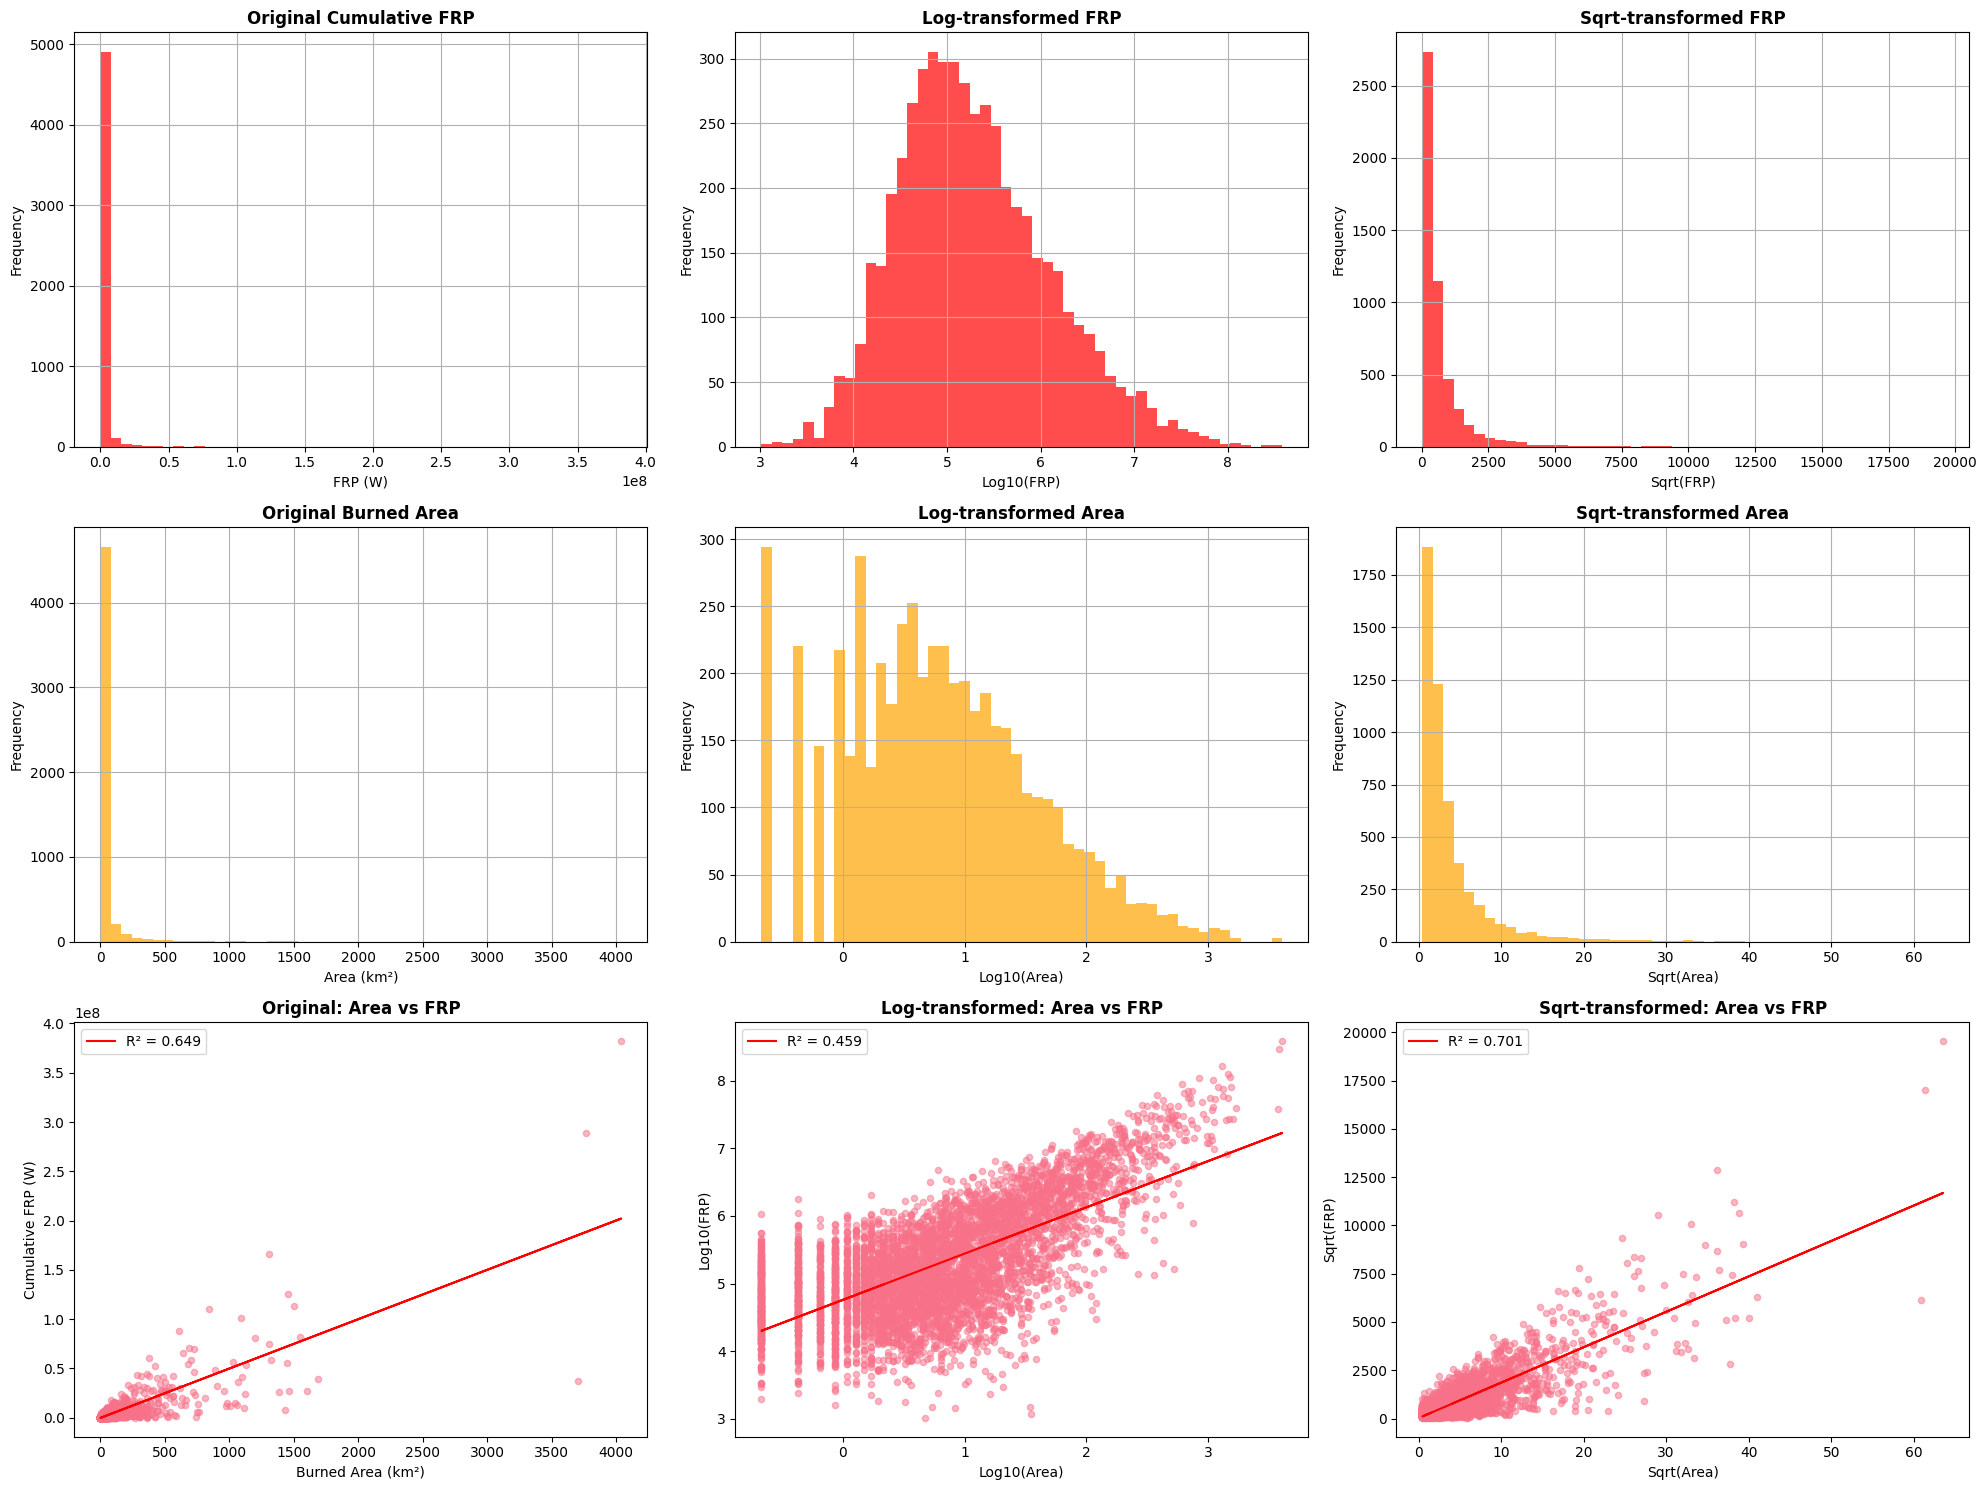


=== RELATIONSHIP ANALYSIS SUMMARY ===
R² Values:
  Original data:      0.6491
  Log-transformed:    0.4590
  Sqrt-transformed:   0.7012

Best transformation: Sqrt (R² = 0.7012)

Data ranges:
  FRP: 1,039 - 382,051,771 W
  Area: 0.21 - 4040.52 km²

ANALYSIS COMPLETE!


In [15]:
# ============================================================================
# COMPREHENSIVE ECOREGION AND FIRE ANALYSIS (STEPS 2-4)
# ============================================================================
print("="*80)
print("COMPREHENSIVE ECOREGION AND FIRE ANALYSIS")
print("="*80)

# Check if ecoregions were loaded in previous cell
if 'ecoregions' not in locals() or ecoregions is None:
    print("❌ Ecoregions not loaded! Please run the ecoregion loading cell first.")
    ecoregions_full = None
else:
    print(f"✓ Using pre-loaded filtered ecoregions ({len(ecoregions)} ecoregions)")
    ecoregions_full = ecoregions  # Use the filtered ecoregions from previous cell

# ============================================================================
# STEP 2: FRP Analysis by Ecoregion
# ============================================================================
print("\n" + "="*50)
print("STEP 2: FRP ANALYSIS BY ECOREGION")
print("="*50)

if ('raw_fired_with_frp' in locals() and 'eco_name' in raw_fired_with_frp.columns and 
    ecoregions_full is not None):
    
    # Aggregate FRP data by fire
    fire_frp_summary = gridstats.groupby('merge_id').agg({
        'frp_csum': 'sum',
        'frp_max': 'max'
    }).reset_index()
    
    # Merge with ecoregion and area information
    ecoregion_data = fire_frp_summary.merge(
        raw_fired_with_frp[['merge_id', 'eco_name', 'tot_ar_km2']], 
        on='merge_id', 
        how='inner'
    )
    
    print(f"Analyzing {len(ecoregion_data)} fires across ecoregions")
    
    # Calculate ecoregion statistics
    ecoregion_stats = ecoregion_data.groupby('eco_name').agg({
        'frp_csum': ['mean', 'std', 'count'],
        'tot_ar_km2': ['sum', 'mean'],
        'merge_id': 'count'
    }).reset_index()
    
    # Flatten column names
    ecoregion_stats.columns = ['eco_name', 'avg_frp_per_fire', 'std_frp_per_fire', 'fire_count_frp',
                              'total_burned_area_km2', 'avg_fire_size_km2', 'fire_count']
    
    # Filter to ecoregions with sufficient fires
    min_fires = 10
    ecoregion_stats_filtered = ecoregion_stats[ecoregion_stats['fire_count'] >= min_fires].copy()
    ecoregion_stats_filtered = ecoregion_stats_filtered.sort_values('avg_frp_per_fire', ascending=False)
    
    print(f"Found {len(ecoregion_stats_filtered)} ecoregions with >= {min_fires} fires")
    
    if len(ecoregion_stats_filtered) > 0:
        # Create dual-axis bar plot
        fig, ax1 = plt.subplots(figsize=(16, 8))
        
        top_ecoregions = ecoregion_stats_filtered.head(20)
        x_pos = range(len(top_ecoregions))
        
        # Average FRP per fire (left y-axis)
        bars1 = ax1.bar([x - 0.2 for x in x_pos], top_ecoregions['avg_frp_per_fire'], 
                       width=0.4, alpha=0.7, color='darkred', label='Avg FRP per Fire')
        
        ax1.set_xlabel('Ecoregion', fontsize=12)
        ax1.set_ylabel('Average FRP per Fire (W)', color='darkred', fontsize=12)
        ax1.tick_params(axis='y', labelcolor='darkred')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels([name[:25] + '...' if len(name) > 25 else name 
                            for name in top_ecoregions['eco_name']], 
                           rotation=45, ha='right')
        
        # Format FRP axis
        if top_ecoregions['avg_frp_per_fire'].max() > 1e6:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax1.set_ylabel('Average FRP per Fire (MW)', color='darkred', fontsize=12)
        elif top_ecoregions['avg_frp_per_fire'].max() > 1e3:
            ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            ax1.set_ylabel('Average FRP per Fire (KW)', color='darkred', fontsize=12)
        
        # Total burned area (right y-axis)
        ax2 = ax1.twinx()
        bars2 = ax2.bar([x + 0.2 for x in x_pos], top_ecoregions['total_burned_area_km2'], 
                       width=0.4, alpha=0.7, color='orange', label='Total Burned Area')
        
        ax2.set_ylabel('Total Burned Area (km²)', color='orange', fontsize=12)
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Format burned area axis
        if top_ecoregions['total_burned_area_km2'].max() > 1e6:
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax2.set_ylabel('Total Burned Area (M km²)', color='orange', fontsize=12)
        elif top_ecoregions['total_burned_area_km2'].max() > 1e3:
            ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            ax2.set_ylabel('Total Burned Area (K km²)', color='orange', fontsize=12)
        
        plt.title('Average FRP per Fire and Total Burned Area by Ecoregion\n(Top 20 by Average FRP)', 
                 fontsize=14, fontweight='bold', pad=20)
        
        # Combined legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics - show ALL ecoregions
        print(f"\n=== ECOREGION SUMMARY STATISTICS ===")
        print(f"All {len(ecoregion_stats_filtered)} ecoregions (sorted by average FRP per fire):")
        print(f"{'Ecoregion Name':<50} | {'Avg FRP':<10} | {'Fires':<6} | {'Total Area':<12} | {'Avg Size':<10}")
        print("-" * 100)
        
        for i, row in ecoregion_stats_filtered.iterrows():
            avg_frp_display = f"{row['avg_frp_per_fire']/1e3:6.1f}K W"
            total_area_display = f"{row['total_burned_area_km2']:8.0f} km²"
            avg_size_display = f"{row['avg_fire_size_km2']:6.1f} km²"
            
            print(f"{row['eco_name'][:48]:48s} | {avg_frp_display:<10} | "
                  f"{row['fire_count']:4d}   | {total_area_display:<12} | {avg_size_display:<10}")
        
        # Additional summary statistics
        print(f"\n=== OVERALL SUMMARY ===")
        total_fires = ecoregion_stats_filtered['fire_count'].sum()
        total_area = ecoregion_stats_filtered['total_burned_area_km2'].sum()
        avg_frp_overall = ecoregion_stats_filtered['avg_frp_per_fire'].mean()
        
        print(f"Total ecoregions analyzed: {len(ecoregion_stats_filtered)}")
        print(f"Total fires: {total_fires:,}")
        print(f"Total burned area: {total_area:,.0f} km²")
        print(f"Average FRP across all ecoregions: {avg_frp_overall/1e3:.1f}K W")
        print(f"Range of avg FRP: {ecoregion_stats_filtered['avg_frp_per_fire'].min()/1e3:.1f}K - {ecoregion_stats_filtered['avg_frp_per_fire'].max()/1e3:.1f}K W")
        print(f"Range of fire counts: {ecoregion_stats_filtered['fire_count'].min()} - {ecoregion_stats_filtered['fire_count'].max()} fires")
        
        # Top 5 by different metrics
        print(f"\nTop 5 by total burned area:")
        top_by_area = ecoregion_stats_filtered.nlargest(5, 'total_burned_area_km2')
        for i, row in top_by_area.iterrows():
            print(f"  {row['eco_name'][:35]:35s} | {row['total_burned_area_km2']:8.0f} km² | {row['fire_count']:4d} fires")
        
        print(f"\nTop 5 by number of fires:")
        top_by_fires = ecoregion_stats_filtered.nlargest(5, 'fire_count')
        for i, row in top_by_fires.iterrows():
            print(f"  {row['eco_name'][:35]:35s} | {row['fire_count']:4d} fires | {row['total_burned_area_km2']:8.0f} km²")
    
else:
    print("❌ Cannot perform ecoregion analysis - missing required data")
    ecoregion_data = None

# ============================================================================
# STEP 3: Choropleth Map - Average FRP per Fire by Ecoregion
# ============================================================================
print("\n" + "="*50)
print("STEP 3: CHOROPLETH MAP - AVERAGE FRP PER FIRE BY ECOREGION")
print("="*50)

from mpl_toolkits.axes_grid1 import make_axes_locatable

if (ecoregions_full is not None and 'gridstats' in locals() and 'states' in locals()):
    
    print("Creating choropleth map of average FRP per fire by ecoregion...")
    
    # Calculate average FRP per fire by ecoregion
    # Group by merge_id first to get one record per fire, then calculate mean FRP per fire
    fire_avg_frp = gridstats.groupby('merge_id').agg({'frp_csum': 'mean'}).reset_index()
    
    # Merge with ecoregion information
    if 'raw_fired_with_frp' in locals() and 'ECO_NAME' in raw_fired_with_frp.columns:
        fire_eco_data = fire_avg_frp.merge(
            raw_fired_with_frp[['merge_id', 'ECO_NAME']], 
            on='merge_id', 
            how='inner'
        )
        
        # Calculate average FRP per fire by ecoregion
        eco_avg_frp = fire_eco_data.groupby('ECO_NAME').agg({
            'frp_csum': 'mean',
            'merge_id': 'count'
        }).reset_index()
        eco_avg_frp.columns = ['ECO_NAME', 'avg_frp_per_fire', 'fire_count']
        
        # Filter to ecoregions with at least 5 fires for statistical significance
        eco_avg_frp_filtered = eco_avg_frp[eco_avg_frp['fire_count'] >= 5].copy()
        
        print(f"Found {len(eco_avg_frp_filtered)} ecoregions with >= 5 fires")
        
        if len(eco_avg_frp_filtered) > 0:
            # Merge with spatial ecoregion data
            ecoregions_with_frp = ecoregions_full.merge(
                eco_avg_frp_filtered, 
                on='ECO_NAME', 
                how='left'
            )
            
            # Convert to geographic coordinates for plotting
            ecoregions_plot = ecoregions_with_frp.to_crs('EPSG:4326')
            states_plot = states.to_crs('EPSG:4326')
            
            # Create the choropleth map
            fig, ax = plt.subplots(figsize=(20, 12))
            
            # Plot state boundaries first (as background)
            states_plot.boundary.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.5)
            
            # Plot ecoregions without data in light gray
            ecoregions_plot[ecoregions_plot['avg_frp_per_fire'].isna()].plot(
                ax=ax, 
                facecolor='lightgray', 
                edgecolor='black', 
                linewidth=0.3, 
                alpha=0.3
            )
            
            # Plot ecoregions with data using choropleth
            ecoregions_with_data = ecoregions_plot[ecoregions_plot['avg_frp_per_fire'].notna()]
            
            if len(ecoregions_with_data) > 0:
                # Create the choropleth
                choropleth = ecoregions_with_data.plot(
                    ax=ax,
                    column='avg_frp_per_fire',
                    cmap='YlOrRd',
                    alpha=0.7,
                    edgecolor='black',
                    linewidth=0.5,
                    legend=False
                )
                
                # Add colorbar
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="3%", pad=0.1)
                
                # Format colorbar based on data range
                max_frp = ecoregions_with_data['avg_frp_per_fire'].max()
                min_frp = ecoregions_with_data['avg_frp_per_fire'].min()
                
                sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                                         norm=plt.Normalize(vmin=min_frp, vmax=max_frp))
                sm.set_array([])
                cbar = plt.colorbar(sm, cax=cax)
                
                if max_frp > 1e6:
                    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}'))
                    cbar.set_label('Average FRP per Fire (MW)', rotation=270, labelpad=20, fontsize=12)
                elif max_frp > 1e3:
                    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}'))
                    cbar.set_label('Average FRP per Fire (KW)', rotation=270, labelpad=20, fontsize=12)
                else:
                    cbar.set_label('Average FRP per Fire (W)', rotation=270, labelpad=20, fontsize=12)
                
                # Add AOI boundary if available
                if 'aoi' in locals() and aoi is not None:
                    aoi_plot = aoi.to_crs('EPSG:4326')
                    aoi_plot.boundary.plot(ax=ax, color='red', linewidth=2, alpha=0.8)
                
                # Format the map
                ax.set_title('Average Fire Radiative Power per Fire by Ecoregion\n(Western United States)', 
                           fontsize=16, fontweight='bold', pad=20)
                ax.set_xlabel('Longitude', fontsize=12)
                ax.set_ylabel('Latitude', fontsize=12)
                ax.grid(True, alpha=0.3)
                
                # Set extent to western US
                ax.set_xlim(-125, -100)
                ax.set_ylim(30, 50)
                
                plt.tight_layout()
                plt.show()
                
                # Display statistics
                print(f"\n=== TOP 10 ECOREGIONS BY AVERAGE FRP PER FIRE ===")
                top_10_frp = eco_avg_frp_filtered.nlargest(10, 'avg_frp_per_fire')
                print(f"{'Rank':<4} | {'Ecoregion Name':<45} | {'Avg FRP (KW)':<12} | {'# Fires':<8}")
                print("-" * 75)
                
                for i, (_, row) in enumerate(top_10_frp.iterrows(), 1):
                    eco_name = row['ECO_NAME'][:43] + '...' if len(row['ECO_NAME']) > 45 else row['ECO_NAME']
                    avg_frp_kw = row['avg_frp_per_fire'] / 1e3
                    print(f"{i:<4} | {eco_name:<45} | {avg_frp_kw:8.1f}    | {row['fire_count']:6d}")
                
                # Overall statistics
                print(f"\n=== OVERALL STATISTICS ===")
                total_fires = eco_avg_frp_filtered['fire_count'].sum()
                weighted_avg_frp = (eco_avg_frp_filtered['avg_frp_per_fire'] * 
                                   eco_avg_frp_filtered['fire_count']).sum() / total_fires
                
                print(f"Total ecoregions with data: {len(eco_avg_frp_filtered)}")
                print(f"Total fires analyzed: {total_fires:,}")
                print(f"Overall weighted average FRP per fire: {weighted_avg_frp/1e3:.1f} KW")
                print(f"Range of avg FRP per fire: {min_frp/1e3:.1f} - {max_frp/1e3:.1f} KW")
                print(f"Range of fire counts per ecoregion: {eco_avg_frp_filtered['fire_count'].min()} - {eco_avg_frp_filtered['fire_count'].max()}")
                
            else:
                print("❌ No ecoregions found with FRP data for mapping")
        else:
            print("❌ No ecoregions found with sufficient fires (>= 5)")
    else:
        print("❌ Missing required data for choropleth mapping")
        print(f"  - raw_fired_with_frp: {'✓' if 'raw_fired_with_frp' in locals() else '❌'}")
        if 'raw_fired_with_frp' in locals():
            print(f"  - ECO_NAME column: {'✓' if 'ECO_NAME' in raw_fired_with_frp.columns else '❌'}")
            print(f"  - Available columns: {list(raw_fired_with_frp.columns)}")
else:
    print("❌ Required data not available for choropleth mapping")
    print(f"  - ecoregions_full: {'✓' if 'ecoregions_full' in locals() else '❌'}")
    print(f"  - gridstats: {'✓' if 'gridstats' in locals() else '❌'}")
    print(f"  - states: {'✓' if 'states' in locals() else '❌'}")

# ============================================================================
# STEP 4: Relationship Analysis - FRP vs Burned Area
# ============================================================================
print("\n" + "="*50)
print("STEP 4: RELATIONSHIP ANALYSIS - FRP VS BURNED AREA")
print("="*50)

if 'ecoregion_data' in locals() and ecoregion_data is not None and len(ecoregion_data) > 0:
    
    # Clean data - remove zeros and nulls
    clean_data = ecoregion_data[(ecoregion_data['frp_csum'] > 0) & 
                               (ecoregion_data['tot_ar_km2'] > 0)].copy()
    
    print(f"Analyzing relationship for {len(clean_data)} fires")
    
    # Apply transformations
    clean_data['frp_log'] = np.log10(clean_data['frp_csum'])
    clean_data['area_log'] = np.log10(clean_data['tot_ar_km2'])
    clean_data['frp_sqrt'] = np.sqrt(clean_data['frp_csum'])
    clean_data['area_sqrt'] = np.sqrt(clean_data['tot_ar_km2'])
    
    # Create comprehensive analysis plot
    fig = plt.figure(figsize=(20, 15))
    
    # Histograms (top row)
    ax1 = plt.subplot(3, 3, 1)
    clean_data['frp_csum'].hist(bins=50, alpha=0.7, color='red', ax=ax1)
    ax1.set_title('Original Cumulative FRP', fontweight='bold')
    ax1.set_xlabel('FRP (W)')
    ax1.set_ylabel('Frequency')
    
    ax2 = plt.subplot(3, 3, 2)
    clean_data['frp_log'].hist(bins=50, alpha=0.7, color='red', ax=ax2)
    ax2.set_title('Log-transformed FRP', fontweight='bold')
    ax2.set_xlabel('Log10(FRP)')
    ax2.set_ylabel('Frequency')
    
    ax3 = plt.subplot(3, 3, 3)
    clean_data['frp_sqrt'].hist(bins=50, alpha=0.7, color='red', ax=ax3)
    ax3.set_title('Sqrt-transformed FRP', fontweight='bold')
    ax3.set_xlabel('Sqrt(FRP)')
    ax3.set_ylabel('Frequency')
    
    ax4 = plt.subplot(3, 3, 4)
    clean_data['tot_ar_km2'].hist(bins=50, alpha=0.7, color='orange', ax=ax4)
    ax4.set_title('Original Burned Area', fontweight='bold')
    ax4.set_xlabel('Area (km²)')
    ax4.set_ylabel('Frequency')
    
    ax5 = plt.subplot(3, 3, 5)
    clean_data['area_log'].hist(bins=50, alpha=0.7, color='orange', ax=ax5)
    ax5.set_title('Log-transformed Area', fontweight='bold')
    ax5.set_xlabel('Log10(Area)')
    ax5.set_ylabel('Frequency')
    
    ax6 = plt.subplot(3, 3, 6)
    clean_data['area_sqrt'].hist(bins=50, alpha=0.7, color='orange', ax=ax6)
    ax6.set_title('Sqrt-transformed Area', fontweight='bold')
    ax6.set_xlabel('Sqrt(Area)')
    ax6.set_ylabel('Frequency')
    
    # Scatter plots with regression lines (bottom row)
    from scipy import stats
    
    # Original data
    ax7 = plt.subplot(3, 3, 7)
    ax7.scatter(clean_data['tot_ar_km2'], clean_data['frp_csum'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['tot_ar_km2'], clean_data['frp_csum'])
    line = slope * clean_data['tot_ar_km2'] + intercept
    ax7.plot(clean_data['tot_ar_km2'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax7.set_title('Original: Area vs FRP', fontweight='bold')
    ax7.set_xlabel('Burned Area (km²)')
    ax7.set_ylabel('Cumulative FRP (W)')
    ax7.legend()
    
    # Log-transformed
    ax8 = plt.subplot(3, 3, 8)
    ax8.scatter(clean_data['area_log'], clean_data['frp_log'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['area_log'], clean_data['frp_log'])
    line = slope * clean_data['area_log'] + intercept
    ax8.plot(clean_data['area_log'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax8.set_title('Log-transformed: Area vs FRP', fontweight='bold')
    ax8.set_xlabel('Log10(Area)')
    ax8.set_ylabel('Log10(FRP)')
    ax8.legend()
    
    # Sqrt-transformed
    ax9 = plt.subplot(3, 3, 9)
    ax9.scatter(clean_data['area_sqrt'], clean_data['frp_sqrt'], alpha=0.5, s=20)
    slope, intercept, r_value, p_value, std_err = stats.linregress(clean_data['area_sqrt'], clean_data['frp_sqrt'])
    line = slope * clean_data['area_sqrt'] + intercept
    ax9.plot(clean_data['area_sqrt'], line, 'r', label=f'R² = {r_value**2:.3f}')
    ax9.set_title('Sqrt-transformed: Area vs FRP', fontweight='bold')
    ax9.set_xlabel('Sqrt(Area)')
    ax9.set_ylabel('Sqrt(FRP)')
    ax9.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\n=== RELATIONSHIP ANALYSIS SUMMARY ===")
    
    # Calculate R² for each transformation
    r2_original = stats.linregress(clean_data['tot_ar_km2'], clean_data['frp_csum'])[2]**2
    r2_log = stats.linregress(clean_data['area_log'], clean_data['frp_log'])[2]**2
    r2_sqrt = stats.linregress(clean_data['area_sqrt'], clean_data['frp_sqrt'])[2]**2
    
    print(f"R² Values:")
    print(f"  Original data:      {r2_original:.4f}")
    print(f"  Log-transformed:    {r2_log:.4f}")
    print(f"  Sqrt-transformed:   {r2_sqrt:.4f}")
    
    # Determine best transformation
    transformations = [('Original', r2_original), ('Log', r2_log), ('Sqrt', r2_sqrt)]
    best_transform = max(transformations, key=lambda x: x[1])
    print(f"\nBest transformation: {best_transform[0]} (R² = {best_transform[1]:.4f})")
    
    # Data ranges
    print(f"\nData ranges:")
    print(f"  FRP: {clean_data['frp_csum'].min():,.0f} - {clean_data['frp_csum'].max():,.0f} W")
    print(f"  Area: {clean_data['tot_ar_km2'].min():.2f} - {clean_data['tot_ar_km2'].max():.2f} km²")
    
else:
    print("❌ Cannot perform relationship analysis - missing data")

print(f"\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

ANALYSIS 4: CUMULATIVE FRP vs MAXIMUM FIRE GROWTH RATE
Analyzing 5111 fires with valid cumulative FRP and growth rate data


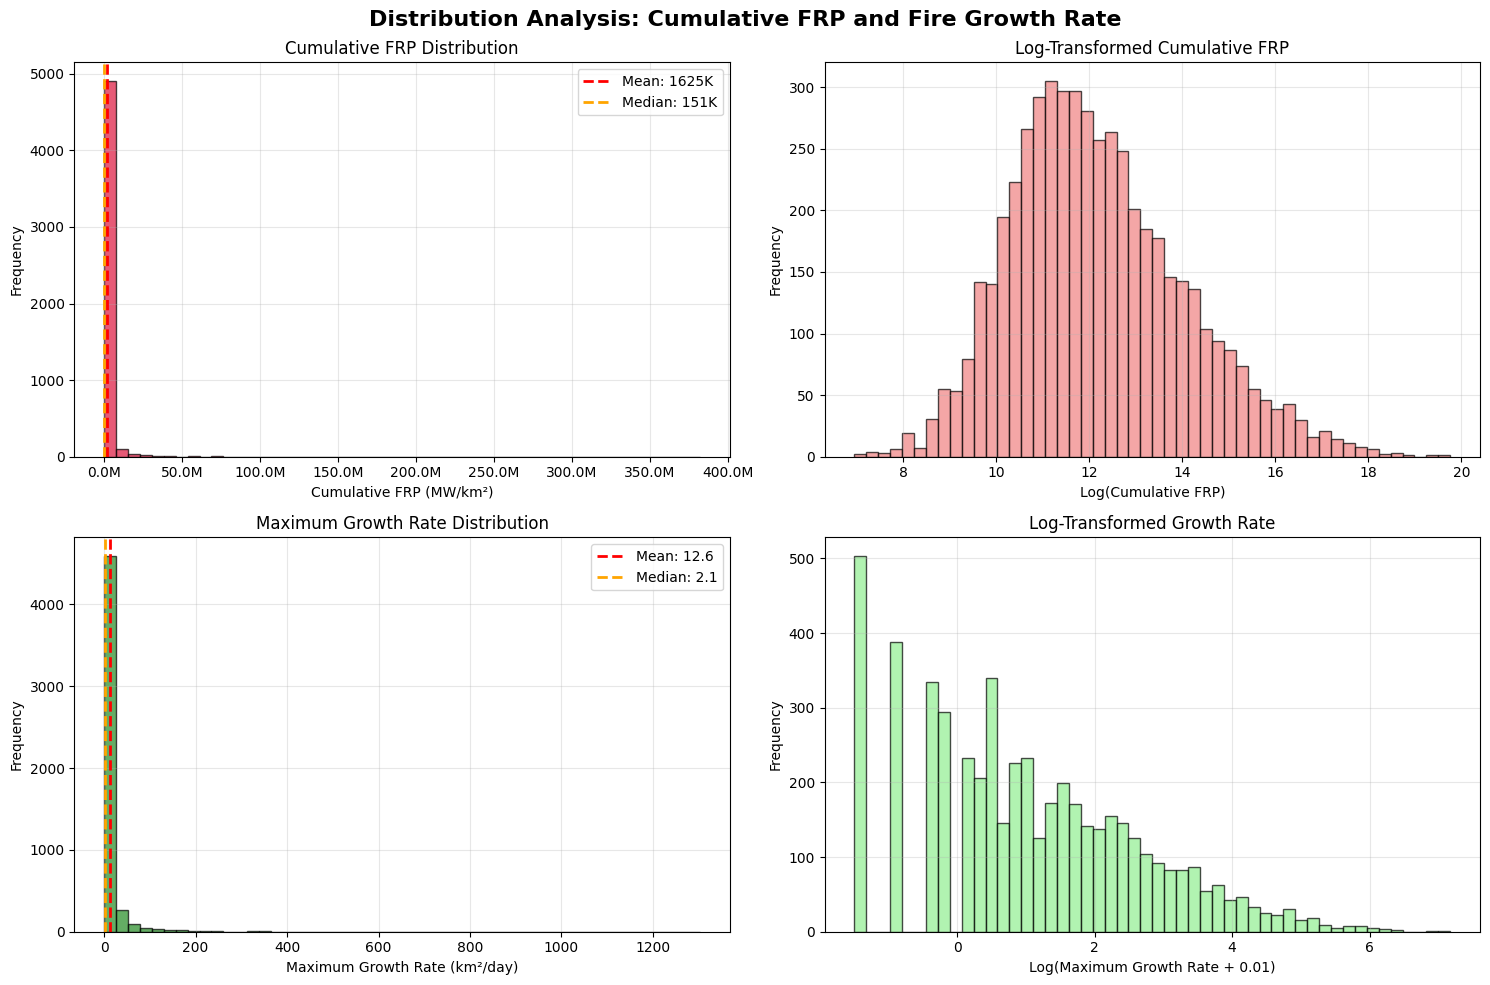


=== DISTRIBUTION ANALYSIS ===
Cumulative FRP (original):
  - Skewness: 23.116
  - Range: 1.0K - 382.1M W/km²
  - Mean: 1625K, Median: 151K
  - Normality test p-value: 0.00e+00 (Non-normal)

Maximum Growth Rate (original):
  - Skewness: 12.301
  - Range: 0.21 - 1302.76 km²/day
  - Mean: 12.60, Median: 2.15
  - Normality test p-value: 0.00e+00 (Non-normal)


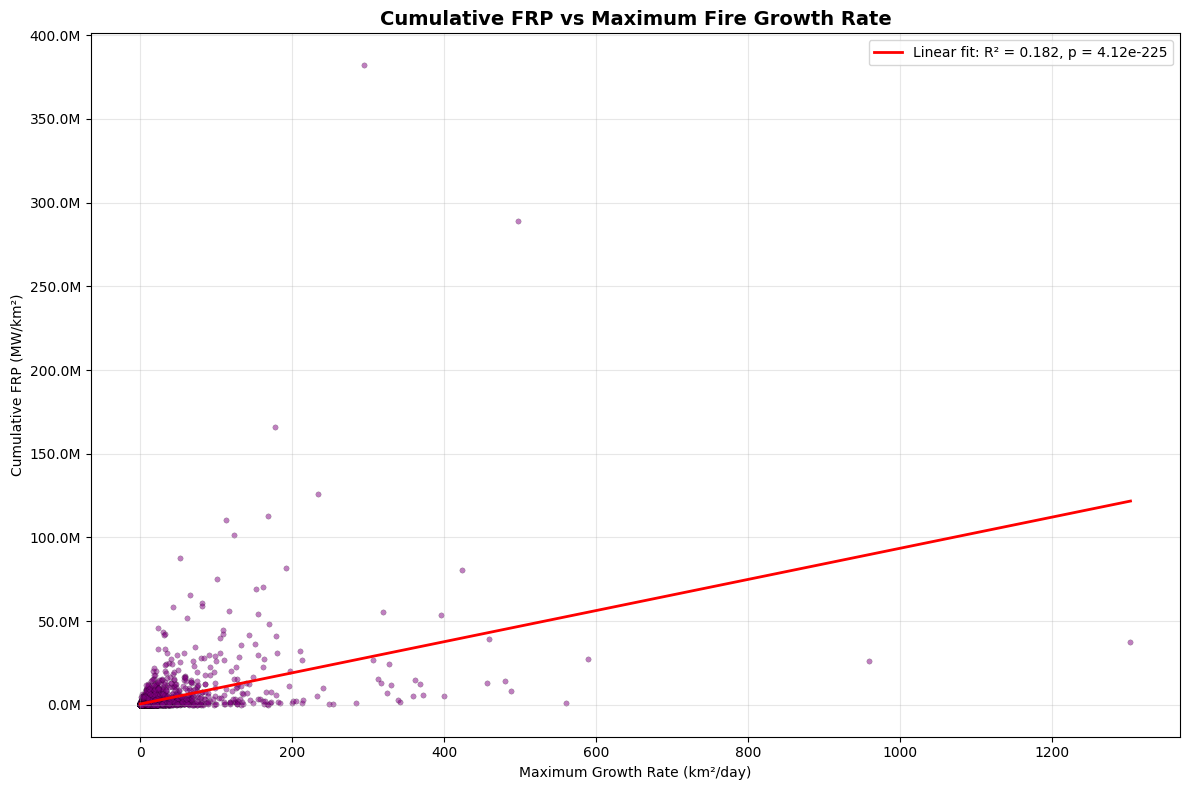


=== CORRELATION ANALYSIS ===
Cumulative FRP vs Maximum Growth Rate:
  - Pearson correlation: 0.4266
  - R-squared: 0.1819
  - P-value: 4.12e-225
  - Significance: ✓ Significant
  - Linear equation: FRP = 93073.84 × GrowthRate + 452184

=== INSIGHTS ===
Growth rate categories:
  - Slow growing (0-25th percentile): ≤ 0.86 km²/day
  - Moderate growing (25-75th percentile): 0.86 - 8.37 km²/day
  - Fast growing (75-90th percentile): 8.37 - 26.62 km²/day
  - Very fast growing (>90th percentile): > 26.62 km²/day
  - Slow growing fires (1,519): avg cumulative FRP = 125.9K W/km²
  - Moderate growing fires (2,328): avg cumulative FRP = 441.8K W/km²
  - Fast growing fires (1,264): avg cumulative FRP = 5603.8K W/km²

Notable fires:
  - Fastest growing: Fire 44896.0 (1302.8 km²/day, 37526.3K W/km² cumulative FRP)
  - Highest cumulative FRP: Fire 198991.0 (382.1M W/km², 294.7 km²/day growth)


In [25]:
# Additional Analysis 4: Cumulative FRP vs Maximum Fire Growth Rate
print("="*60)
print("ANALYSIS 4: CUMULATIVE FRP vs MAXIMUM FIRE GROWTH RATE")
print("="*60)

if 'raw_fired_with_frp' in locals() and 'mx_grw_km2' in raw_fired_with_frp.columns:
    # Aggregate FRP data by fire (merge_id) and merge with growth rate data
    fire_growth_data = gridstats.groupby('merge_id').agg({
        'frp_csum': 'sum'            # Total cumulative FRP for each fire
    }).reset_index()
    
    # Merge with raw FIRED data to get maximum growth rate
    fire_growth_data = fire_growth_data.merge(
        raw_fired_with_frp[['merge_id', 'mx_grw_km2']], 
        on='merge_id', 
        how='inner'
    )
    
    # Remove fires with zero or missing values
    fire_growth_data = fire_growth_data[
        (fire_growth_data['frp_csum'] > 0) & 
        (fire_growth_data['mx_grw_km2'] > 0) & 
        (fire_growth_data['mx_grw_km2'].notna())
    ]
    
    print(f"Analyzing {len(fire_growth_data)} fires with valid cumulative FRP and growth rate data")
    
    if len(fire_growth_data) > 0:
        # Create histograms to assess normality
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Distribution Analysis: Cumulative FRP and Fire Growth Rate', fontsize=16, fontweight='bold')
        
        # 1. Cumulative FRP histogram
        axes[0,0].hist(fire_growth_data['frp_csum'], bins=50, alpha=0.7, color='crimson', edgecolor='black')
        axes[0,0].set_title('Cumulative FRP Distribution')
        axes[0,0].set_xlabel('Cumulative FRP (W/km²)')
        axes[0,0].set_ylabel('Frequency')
        axes[0,0].grid(True, alpha=0.3)
        
        # Format FRP axis
        if fire_growth_data['frp_csum'].max() > 1e6:
            axes[0,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            axes[0,0].set_xlabel('Cumulative FRP (MW/km²)')
        elif fire_growth_data['frp_csum'].max() > 1e3:
            axes[0,0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            axes[0,0].set_xlabel('Cumulative FRP (KW/km²)')
        
        # Add statistics
        frp_mean = fire_growth_data['frp_csum'].mean()
        frp_median = fire_growth_data['frp_csum'].median()
        axes[0,0].axvline(frp_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {frp_mean/1e3:.0f}K')
        axes[0,0].axvline(frp_median, color='orange', linestyle='--', linewidth=2, label=f'Median: {frp_median/1e3:.0f}K')
        axes[0,0].legend()
        
        # 2. Log-transformed Cumulative FRP
        log_frp = np.log(fire_growth_data['frp_csum'])
        axes[0,1].hist(log_frp, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Log-Transformed Cumulative FRP')
        axes[0,1].set_xlabel('Log(Cumulative FRP)')
        axes[0,1].set_ylabel('Frequency')
        axes[0,1].grid(True, alpha=0.3)
        
        # 3. Growth Rate histogram
        axes[1,0].hist(fire_growth_data['mx_grw_km2'], bins=50, alpha=0.7, color='forestgreen', edgecolor='black')
        axes[1,0].set_title('Maximum Growth Rate Distribution')
        axes[1,0].set_xlabel('Maximum Growth Rate (km²/day)')
        axes[1,0].set_ylabel('Frequency')
        axes[1,0].grid(True, alpha=0.3)
        
        # Add statistics
        growth_mean = fire_growth_data['mx_grw_km2'].mean()
        growth_median = fire_growth_data['mx_grw_km2'].median()
        axes[1,0].axvline(growth_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {growth_mean:.1f}')
        axes[1,0].axvline(growth_median, color='orange', linestyle='--', linewidth=2, label=f'Median: {growth_median:.1f}')
        axes[1,0].legend()
        
        # 4. Log-transformed Growth Rate
        # Add small constant to handle zeros if any
        growth_rate_adj = fire_growth_data['mx_grw_km2'] + 0.01
        log_growth = np.log(growth_rate_adj)
        axes[1,1].hist(log_growth, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
        axes[1,1].set_title('Log-Transformed Growth Rate')
        axes[1,1].set_xlabel('Log(Maximum Growth Rate + 0.01)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Statistical analysis of distributions
        from scipy.stats import skew, normaltest
        
        print(f"\n=== DISTRIBUTION ANALYSIS ===")
        print(f"Cumulative FRP (original):")
        print(f"  - Skewness: {skew(fire_growth_data['frp_csum']):.3f}")
        print(f"  - Range: {fire_growth_data['frp_csum'].min()/1e3:.1f}K - {fire_growth_data['frp_csum'].max()/1e6:.1f}M W/km²")
        print(f"  - Mean: {frp_mean/1e3:.0f}K, Median: {frp_median/1e3:.0f}K")
        
        stat_frp, p_frp = normaltest(fire_growth_data['frp_csum'])
        print(f"  - Normality test p-value: {p_frp:.2e} {'(Normal)' if p_frp > 0.05 else '(Non-normal)'}")
        
        print(f"\nMaximum Growth Rate (original):")
        print(f"  - Skewness: {skew(fire_growth_data['mx_grw_km2']):.3f}")
        print(f"  - Range: {fire_growth_data['mx_grw_km2'].min():.2f} - {fire_growth_data['mx_grw_km2'].max():.2f} km²/day")
        print(f"  - Mean: {growth_mean:.2f}, Median: {growth_median:.2f}")
        
        stat_growth, p_growth = normaltest(fire_growth_data['mx_grw_km2'])
        print(f"  - Normality test p-value: {p_growth:.2e} {'(Normal)' if p_growth > 0.05 else '(Non-normal)'}")
        
        # Correlation analysis and scatter plot
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        
        # Scatter plot
        scatter = ax.scatter(fire_growth_data['mx_grw_km2'], fire_growth_data['frp_csum'], 
                           alpha=0.5, c='purple', s=15, edgecolors='black', linewidth=0.2)
        
        # Calculate correlation and regression
        from scipy import stats
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            fire_growth_data['mx_grw_km2'], fire_growth_data['frp_csum']
        )
        
        # Line of best fit
        x_line = np.linspace(fire_growth_data['mx_grw_km2'].min(), 
                           fire_growth_data['mx_grw_km2'].max(), 100)
        y_line = slope * x_line + intercept
        
        ax.plot(x_line, y_line, 'red', linewidth=2, 
               label=f'Linear fit: R² = {r_value**2:.3f}, p = {p_value:.2e}')
        
        # Formatting
        ax.set_title('Cumulative FRP vs Maximum Fire Growth Rate', fontsize=14, fontweight='bold')
        ax.set_xlabel('Maximum Growth Rate (km²/day)')
        ax.set_ylabel('Cumulative FRP (W/km²)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Format y-axis
        if fire_growth_data['frp_csum'].max() > 1e6:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
            ax.set_ylabel('Cumulative FRP (MW/km²)')
        elif fire_growth_data['frp_csum'].max() > 1e3:
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))
            ax.set_ylabel('Cumulative FRP (KW/km²)')
        
        plt.tight_layout()
        plt.show()
        
        # Detailed correlation results
        print(f"\n=== CORRELATION ANALYSIS ===")
        print(f"Cumulative FRP vs Maximum Growth Rate:")
        print(f"  - Pearson correlation: {r_value:.4f}")
        print(f"  - R-squared: {r_value**2:.4f}")
        print(f"  - P-value: {p_value:.2e}")
        print(f"  - Significance: {'✓ Significant' if p_value < 0.05 else '✗ Not significant'}")
        print(f"  - Linear equation: FRP = {slope:.2f} × GrowthRate + {intercept:.0f}")
        
        # Additional insights
        print(f"\n=== INSIGHTS ===")
        
        # Categorize fires by growth rate
        growth_percentiles = np.percentile(fire_growth_data['mx_grw_km2'], [25, 50, 75, 90])
        
        print(f"Growth rate categories:")
        print(f"  - Slow growing (0-25th percentile): ≤ {growth_percentiles[0]:.2f} km²/day")
        print(f"  - Moderate growing (25-75th percentile): {growth_percentiles[0]:.2f} - {growth_percentiles[2]:.2f} km²/day")
        print(f"  - Fast growing (75-90th percentile): {growth_percentiles[2]:.2f} - {growth_percentiles[3]:.2f} km²/day")
        print(f"  - Very fast growing (>90th percentile): > {growth_percentiles[3]:.2f} km²/day")
        
        # Average FRP by growth category
        for i, (label, threshold) in enumerate([
            ("Slow", growth_percentiles[0]),
            ("Moderate", growth_percentiles[2]),
            ("Fast", growth_percentiles[3])
        ]):
            if i == 0:
                mask = fire_growth_data['mx_grw_km2'] <= threshold
            elif i == 1:
                mask = (fire_growth_data['mx_grw_km2'] > growth_percentiles[0]) & (fire_growth_data['mx_grw_km2'] <= threshold)
            else:
                mask = fire_growth_data['mx_grw_km2'] > growth_percentiles[2]
            
            avg_frp = fire_growth_data[mask]['frp_csum'].mean()
            count = mask.sum()
            print(f"  - {label} growing fires ({count:,}): avg cumulative FRP = {avg_frp/1e3:.1f}K W/km²")
        
        # Outlier identification
        fastest_fire = fire_growth_data.loc[fire_growth_data['mx_grw_km2'].idxmax()]
        highest_frp_fire = fire_growth_data.loc[fire_growth_data['frp_csum'].idxmax()]
        
        print(f"\nNotable fires:")
        print(f"  - Fastest growing: Fire {fastest_fire['merge_id']} ({fastest_fire['mx_grw_km2']:.1f} km²/day, "
              f"{fastest_fire['frp_csum']/1e3:.1f}K W/km² cumulative FRP)")
        print(f"  - Highest cumulative FRP: Fire {highest_frp_fire['merge_id']} ({highest_frp_fire['frp_csum']/1e6:.1f}M W/km², "
              f"{highest_frp_fire['mx_grw_km2']:.1f} km²/day growth)")
        
    else:
        print("No valid data found for FRP vs growth rate analysis")
        
else:
    print("Warning: Raw FIRED data with 'mx_grw_km2' column not available")


In [ ]:
# WWF Ecoregion Spatial Analysis - Simplified Version
print("="*60)
print("WWF ECOREGION SPATIAL ANALYSIS - DIRECT APPROACH")
print("="*60)

if (ecoregions_full is not None and 'fires' in locals()):
    
    # Use ECO_NAME column directly from WWF data
    wwf_name_column = 'ECO_NAME'
    
    if wwf_name_column in ecoregions_full.columns:
        print(f"✓ Found WWF ecoregion column: {wwf_name_column}")
        
        # Get all unique ecoregion names and look for target patterns
        unique_ecoregions = ecoregions_full[wwf_name_column].unique()
        print(f"Total WWF ecoregions: {len(unique_ecoregions)}")
        
        # Search patterns for target forest ecoregions
        target_patterns = [
            'sierra', 'nevada', 'california', 'klamath', 'siskiyou', 
            'cascade', 'oregon', 'conifer', 'temperate', 'mixed', 'forest'
        ]
        
        # Find candidate ecoregions
        target_candidates = []
        forest_candidates = []
        
        print(f"\\nSearching for target ecoregions...")
        for eco in sorted(unique_ecoregions):
            eco_lower = str(eco).lower()
            
            # Look for any target patterns
            if any(pattern in eco_lower for pattern in target_patterns):
                if any(forest_word in eco_lower for forest_word in ['forest', 'conifer', 'temperate']):
                    target_candidates.append(eco)
                else:
                    forest_candidates.append(eco)
        
        print(f"Target forest ecoregions found: {len(target_candidates)}")
        for eco in target_candidates:
            print(f"  - {eco}")
            
        print(f"\\nOther relevant ecoregions: {len(forest_candidates)}")
        for eco in forest_candidates[:10]:  # Show first 10
            print(f"  - {eco}")
        
        # Use target ecoregions, or fall back to forest candidates
        if target_candidates:
            wwf_target_ecoregions = target_candidates
        elif forest_candidates:
            wwf_target_ecoregions = forest_candidates[:5]  # Take first 5
        else:
            # Manual selection of likely candidates based on common WWF ecoregion names
            likely_targets = []
            for eco in unique_ecoregions:
                eco_str = str(eco)
                if any(word in eco_str for word in ['California', 'Oregon', 'Washington', 'Mixed', 'Conifer']):
                    likely_targets.append(eco)
            wwf_target_ecoregions = likely_targets[:5]
        
        print(f"\\n=== FINAL TARGET ECOREGIONS ({len(wwf_target_ecoregions)}) ===")
        for i, eco in enumerate(wwf_target_ecoregions, 1):
            print(f"  {i}. {eco}")
        
        # Proceed with spatial analysis if we have targets
        if wwf_target_ecoregions and 'ecoregion_data' in locals():
            
            # Convert to geographic coordinates
            ecoregions_geo = ecoregions_full.to_crs('EPSG:4326') if ecoregions_full.crs != 'EPSG:4326' else ecoregions_full
            
            # Find target ecoregions in spatial data
            target_eco_spatial = ecoregions_geo[ecoregions_geo[wwf_name_column].isin(wwf_target_ecoregions)]
            print(f"\\nSpatial ecoregions found: {len(target_eco_spatial)}")
            
            if len(target_eco_spatial) > 0:
                # Prepare fire data with geometries
                fire_map_data = ecoregion_data.merge(
                    fires[['merge_id', 'geometry']], 
                    on='merge_id', 
                    how='left'
                )
                fire_map_data = gpd.GeoDataFrame(fire_map_data, geometry='geometry', crs=fires.crs)
                
                # Ensure same CRS
                if fire_map_data.crs != target_eco_spatial.crs:
                    fire_map_data = fire_map_data.to_crs(target_eco_spatial.crs)
                
                # Spatial intersection of fires with target ecoregions
                print("Performing spatial intersection...")
                target_fires = gpd.sjoin(fire_map_data, target_eco_spatial, how='inner', predicate='intersects')
                
                print(f"Found {len(target_fires)} fires in target WWF ecoregions!")
                
                if len(target_fires) > 0:
                    # Convert to geographic coordinates for plotting
                    target_fires_geo = target_fires.to_crs('EPSG:4326')
                    target_eco_geo = target_eco_spatial.to_crs('EPSG:4326')
                    
                    # Create the map
                    fig, ax = plt.subplots(figsize=(18, 12))
                    
                    # Plot all WWF ecoregions as backdrop
                    ecoregions_geo.plot(ax=ax, facecolor='lightgray', edgecolor='white', 
                                       linewidth=0.2, alpha=0.3)
                    
                    # Highlight target ecoregions
                    target_eco_geo.plot(ax=ax, facecolor='lightblue', edgecolor='blue', 
                                       linewidth=1.5, alpha=0.6, label='Target WWF Ecoregions')
                    
                    # Add AOI boundary
                    if 'aoi' in locals():
                        aoi_plot = aoi.to_crs('EPSG:4326') if aoi.crs != 'EPSG:4326' else aoi
                        aoi_plot.boundary.plot(ax=ax, color='black', linewidth=2, alpha=0.8, label='Western US AOI')
                    
                    # Plot fires colored by cumulative FRP
                    scatter = ax.scatter(
                        target_fires_geo.geometry.centroid.x,
                        target_fires_geo.geometry.centroid.y,
                        c=target_fires_geo['frp_csum'],
                        cmap='Reds',
                        s=80,
                        alpha=0.8,
                        edgecolors='black',
                        linewidth=0.5,
                        label='Forest Fires'
                    )
                    
                    # Add colorbar
                    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
                    max_frp = target_fires_geo['frp_csum'].max()
                    if max_frp > 1e9:
                        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e9:.1f}B'))
                        cbar.set_label('Cumulative FRP (GW)', rotation=270, labelpad=20)
                    elif max_frp > 1e6:
                        cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
                        cbar.set_label('Cumulative FRP (MW)', rotation=270, labelpad=20)
                    else:
                        cbar.set_label('Cumulative FRP (W)', rotation=270, labelpad=20)
                    
                    # Format map
                    ax.set_title('Forest Fires in Target WWF Ecoregions\\nColored by Cumulative Fire Radiative Power', 
                                fontsize=16, fontweight='bold', pad=20)
                    ax.set_xlabel('Longitude', fontsize=12)
                    ax.set_ylabel('Latitude', fontsize=12)
                    ax.grid(True, alpha=0.3)
                    ax.legend(loc='lower left', fontsize=10)
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Summary statistics
                    print(f"\\n=== FIRE STATISTICS BY ECOREGION ===")
                    ecoregion_col = wwf_name_column + '_right'  # After spatial join
                    
                    if ecoregion_col in target_fires_geo.columns:
                        for eco_name in wwf_target_ecoregions:
                            eco_fires = target_fires_geo[target_fires_geo[ecoregion_col] == eco_name]
                            if len(eco_fires) > 0:
                                avg_frp = eco_fires['frp_csum'].mean()
                                total_area = eco_fires['tot_ar_km2'].sum()
                                max_frp = eco_fires['frp_csum'].max()
                                min_frp = eco_fires['frp_csum'].min()
                                
                                print(f"\\n{eco_name}:")
                                print(f"  Fires: {len(eco_fires):,}")
                                print(f"  Avg FRP: {avg_frp/1e6:.2f} MW")
                                print(f"  Total burned: {total_area:,.0f} km²")
                                print(f"  FRP range: {min_frp/1e6:.2f} - {max_frp/1e6:.2f} MW")
                                print(f"  Avg fire size: {total_area/len(eco_fires):.1f} km²")
                    
                    # Overall summary
                    total_fires = len(target_fires_geo)
                    total_frp = target_fires_geo['frp_csum'].sum()
                    total_area = target_fires_geo['tot_ar_km2'].sum()
                    
                    print(f"\\n=== OVERALL SUMMARY ===")
                    print(f"Total fires: {total_fires:,}")
                    print(f"Total cumulative FRP: {total_frp/1e9:.2f} GW")
                    print(f"Total burned area: {total_area:,.0f} km²")
                    print(f"Average FRP per fire: {total_frp/total_fires/1e6:.2f} MW")
                    print(f"Average fire size: {total_area/total_fires:.1f} km²")
                    
                else:
                    print("❌ No fires found in target ecoregions")
            else:
                print("❌ No target ecoregions found in spatial data")
        else:
            print("❌ No target ecoregions identified or fire data missing")
    else:
        print(f"❌ Column {wwf_name_column} not found in ecoregions data")
        print(f"Available columns: {list(ecoregions_full.columns)}")
else:
    print("❌ Required data not available")
    print(f"  - ecoregions_full: {'✓' if 'ecoregions_full' in locals() else '❌'}")
    print(f"  - fires: {'✓' if 'fires' in locals() else '❌'}")
    print(f"  - ecoregion_data: {'✓' if 'ecoregion_data' in locals() else '❌'}")


In [ ]:
# Examine WWF Ecoregions Data Structure and Find Target Ecoregions
print("="*60)
print("WWF ECOREGIONS EXAMINATION & TARGET IDENTIFICATION")
print("="*60)

if 'ecoregions_full' in locals() and ecoregions_full is not None:
    print("WWF Ecoregions dataframe info:")
    print(f"Shape: {ecoregions_full.shape}")
    print(f"Columns: {list(ecoregions_full.columns)}")
    print()
    
    # Look for name columns in WWF data
    name_cols = [col for col in ecoregions_full.columns if 'name' in col.lower()]
    print(f"Columns with 'name': {name_cols}")
    
    # Check common WWF ecoregion column names
    possible_name_cols = ['ECO_NAME', 'BIOME_NAME', 'WWF_MHTNAM', 'WWF_REALM', 'BIOME', 'ECO_ID']
    available_name_cols = [col for col in possible_name_cols if col in ecoregions_full.columns]
    print(f"Available WWF name columns: {available_name_cols}")
    print()
    
    # Display first few rows to see data structure
    print("Sample data:")
    if len(ecoregions_full) > 0:
        display_cols = [col for col in ecoregions_full.columns if col != 'geometry'][:8]
        print(ecoregions_full[display_cols].head())
    print()
    
    # Find the main name column and display unique values
    main_name_col = None
    if 'ECO_NAME' in ecoregions_full.columns:
        main_name_col = 'ECO_NAME'
    elif name_cols:
        main_name_col = name_cols[0]
    
    if main_name_col:
        unique_ecoregions = ecoregions_full[main_name_col].unique()
        print(f"Found {len(unique_ecoregions)} unique ecoregions in {main_name_col}")
        
        # Look specifically for forest ecoregions containing target patterns
        print(f"\n=== SEARCHING FOR TARGET FOREST ECOREGIONS ===")
        sierra_patterns = ['sierra', 'nevada', 'california']
        klamath_patterns = ['klamath', 'siskiyou', 'cascade', 'oregon']
        forest_patterns = ['forest', 'conifer', 'temperate', 'mixed']
        
        sierra_candidates = []
        klamath_candidates = []
        forest_ecos = []
        
        for eco in sorted(unique_ecoregions):
            eco_str = str(eco).lower()
            
            # Check for forest ecoregions
            if any(pattern in eco_str for pattern in forest_patterns):
                forest_ecos.append(eco)
            
            # Check for Sierra Nevada patterns
            if any(pattern in eco_str for pattern in sierra_patterns):
                sierra_candidates.append(eco)
                
            # Check for Klamath-Siskiyou patterns  
            if any(pattern in eco_str for pattern in klamath_patterns):
                klamath_candidates.append(eco)
        
        print(f"Forest ecoregions found ({len(forest_ecos)}):")
        for eco in forest_ecos[:10]:  # Show first 10
            print(f"  - {eco}")
        if len(forest_ecos) > 10:
            print(f"  ... and {len(forest_ecos)-10} more")
        
        print(f"\nSierra Nevada/California candidates ({len(sierra_candidates)}):")
        for eco in sierra_candidates:
            print(f"  - {eco}")
            
        print(f"\nKlamath-Siskiyou/Cascade candidates ({len(klamath_candidates)}):")
        for eco in klamath_candidates:
            print(f"  - {eco}")
        
        # Identify the specific target ecoregions
        target_ecoregions_wwf = sierra_candidates + klamath_candidates
        print(f"\n=== TARGET ECOREGIONS IDENTIFIED ===")
        print(f"Total target ecoregions: {len(target_ecoregions_wwf)}")
        for i, eco in enumerate(target_ecoregions_wwf, 1):
            print(f"  {i}. {eco}")
        
        # Store for later use
        wwf_name_column = main_name_col
        wwf_target_ecoregions = target_ecoregions_wwf
        
        print(f"\n✓ WWF ecoregion analysis complete!")
        print(f"  - Name column: {wwf_name_column}")
        print(f"  - Target ecoregions: {len(wwf_target_ecoregions)}")
        
    else:
        print("❌ No suitable name column found in WWF ecoregions data")
        print("Available columns:", list(ecoregions_full.columns))
        
else:
    print("❌ WWF ecoregions not loaded - run the previous cell first")


Showing 1,976,700 grid cells with FRP > 80th percentile


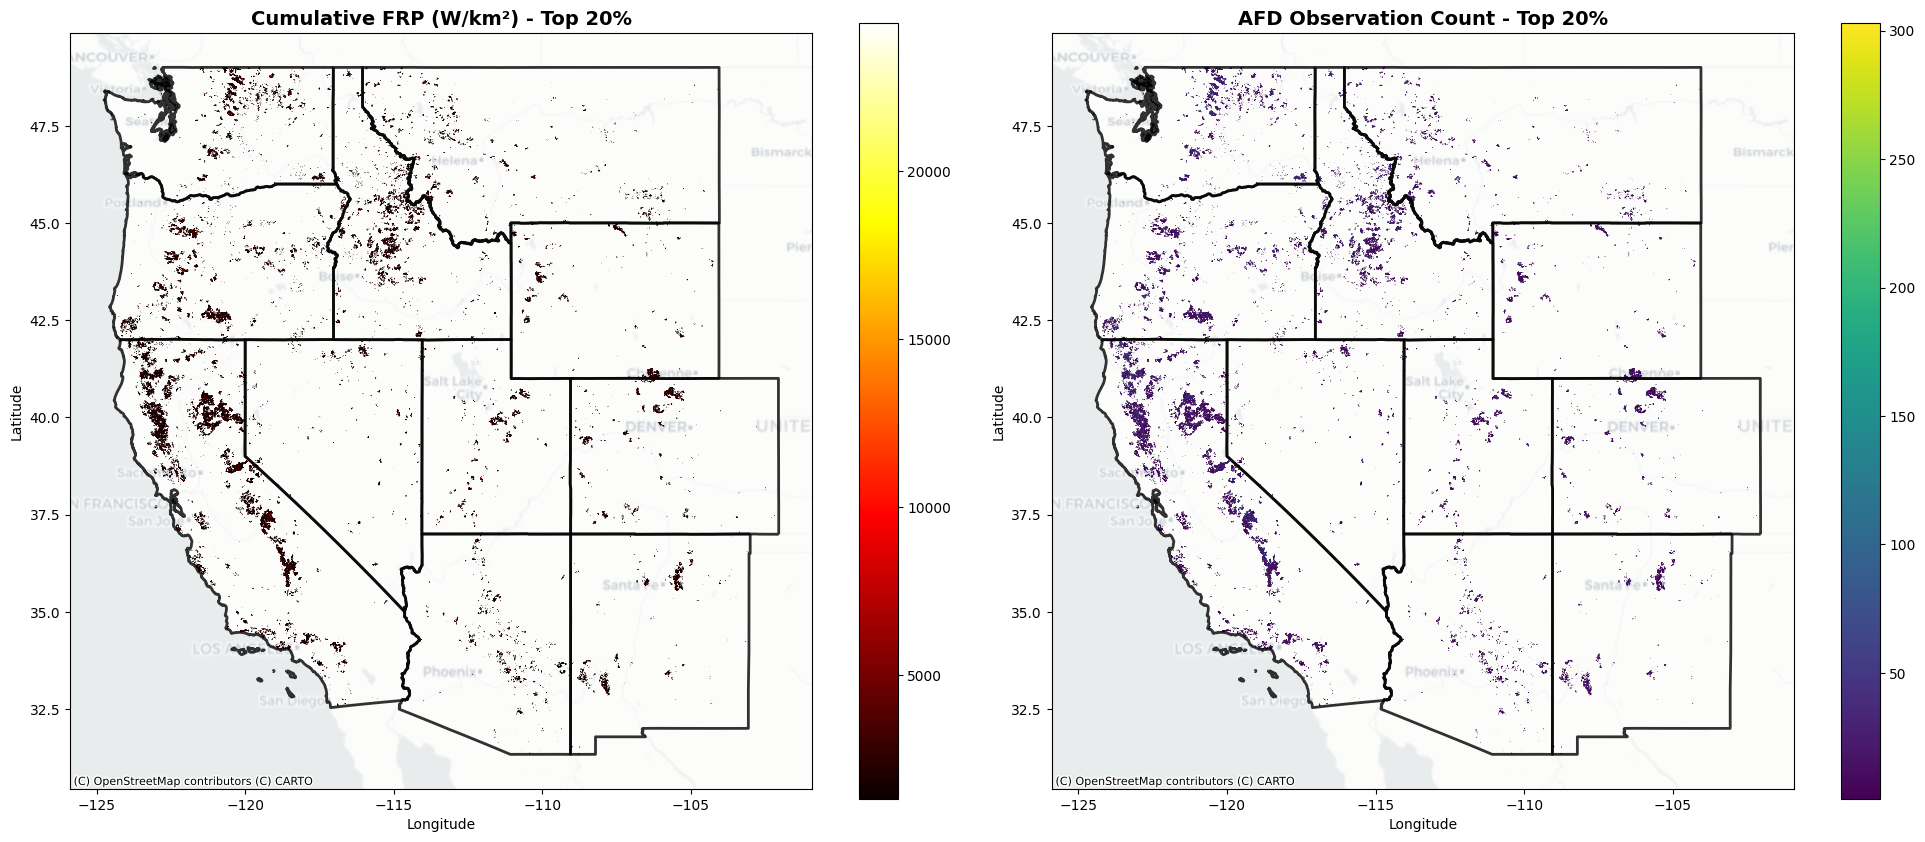

In [10]:
# Create spatial maps of FRP patterns
if 'gridstats' in locals() and 'frp_csum' in gridstats.columns:
    
    # Filter to high FRP areas for better visualization
    high_frp = gridstats[gridstats['frp_csum'] > gridstats['frp_csum'].quantile(0.80)].copy()
    print(f"Showing {len(high_frp):,} grid cells with FRP > 80th percentile")
    
    # Convert to geographic coordinates for web map overlay
    high_frp_geo = high_frp.to_crs('EPSG:4326')
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Map 1: Cumulative FRP
    if 'aoi' in locals():
        aoi.to_crs('EPSG:4326').boundary.plot(ax=axes[0], color='black', linewidth=2, alpha=0.8)
    
    im1 = high_frp_geo.plot(column='frp_csum', 
                           ax=axes[0], 
                           cmap='hot', 
                           markersize=2,
                           alpha=0.8,
                           legend=True,
                           legend_kwds={'shrink': 0.8})
    
    axes[0].set_title('Cumulative FRP (W/km²) - Top 20%', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Longitude')
    axes[0].set_ylabel('Latitude')
    
    # Add basemap
    try:
        ctx.add_basemap(axes[0], crs=high_frp_geo.crs, source=ctx.providers.CartoDB.Positron, alpha=0.5)
    except:
        print("Could not add basemap - continuing without")
    
    # Map 2: AFD observation density
    if 'afd_count' in gridstats.columns:
        if 'aoi' in locals():
            aoi.to_crs('EPSG:4326').boundary.plot(ax=axes[1], color='black', linewidth=2, alpha=0.8)
        
        im2 = high_frp_geo.plot(column='afd_count', 
                               ax=axes[1], 
                               cmap='viridis', 
                               markersize=2,
                               alpha=0.8,
                               legend=True,
                               legend_kwds={'shrink': 0.8})
        
        axes[1].set_title('AFD Observation Count - Top 20%', fontsize=14, fontweight='bold')
        axes[1].set_xlabel('Longitude')
        axes[1].set_ylabel('Latitude')
        
        # Add basemap
        try:
            ctx.add_basemap(axes[1], crs=high_frp_geo.crs, source=ctx.providers.CartoDB.Positron, alpha=0.5)
        except:
            print("Could not add basemap - continuing without")
    
    plt.tight_layout()
    plt.show()
